In [ ]:
!pip install umap


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip


In [ ]:
!pip3 install hdbscan

Defaulting to user installation because normal site-packages is not writeable
  Using cached hdbscan-0.8.29.tar.gz (5.2 MB)
  distutils: /private/var/folders/1x/7bmwc88d3t7_tlg5n48qmqyh0000gn/T/pip-build-env-pg_s98x4/normal/lib/python3.9/site-packages
  sysconfig: /Library/Python/3.9/site-packages
  distutils: /private/var/folders/1x/7bmwc88d3t7_tlg5n48qmqyh0000gn/T/pip-build-env-pg_s98x4/normal/lib/python3.9/site-packages
  sysconfig: /Library/Python/3.9/site-packages
  user = False
  home = None
  root = None
  prefix = '/private/var/folders/1x/7bmwc88d3t7_tlg5n48qmqyh0000gn/T/pip-build-env-pg_s98x4/normal'
  distutils: /private/var/folders/1x/7bmwc88d3t7_tlg5n48qmqyh0000gn/T/pip-build-env-pg_s98x4/overlay/lib/python3.9/site-packages
  sysconfig: /Library/Python/3.9/site-packages
  distutils: /private/var/folders/1x/7bmwc88d3t7_tlg5n48qmqyh0000gn/T/pip-build-env-pg_s98x4/overlay/lib/python3.9/site-packages
  sysconfig: /Library/Python/3.9/site-packages
  user = False
  home = None
  

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from time import time
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans,  AgglomerativeClustering, DBSCAN
from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, v_measure_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score

import hdbscan
import umap.umap_ as umap
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]

# Set the random seed to ensure consistency
SEED = 0
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
import re
def clean(text):
#     text = re.sub(r'^([^\s:]+):.*\n', '', text, flags=re.MULTILINE)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
    texter = re.sub(r'\b[0-9]+\b\s*', '', text) # Exclude purely numbers terms
    texter = re.sub(r"<br />", " ", texter)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub('\t', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub('\-*', '', texter)
#     texter = re.sub('\|*', '', texter)
#     texter = re.sub('\>*', '', texter)
#     texter = re.sub('\**', '', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    texter = re.sub('  ', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [ ]:
# newsgroups_all_original = fetch_20newsgroups(subset='all')
# print(type(newsgroups_all_original))
# print(newsgroups_all_original.target_names[0])
# df = pd.DataFrame(newsgroups_all_original['data', 'target'], columns=['full_text'])
# df['clean_text'] =  df['full_text'].apply(clean)

# pipe = Pipeline([
#     ('count', CountVectorizer(stop_words='english', min_df=3)),
#     ('tfidf', TfidfTransformer())])

# df_X = pipe.fit_transform(df["clean_text"])

# print(f'Dataset shape: {df_X.shape}')

# QUESTION 1
### Report the dimensions of the TF-IDF matrix you obtain.

In [ ]:
def evaluate(truth_labels, km_labels):
    scores = [
        metrics.homogeneity_score(truth_labels, km_labels),
        metrics.completeness_score(truth_labels, km_labels),
        metrics.v_measure_score(truth_labels, km_labels),
        metrics.adjusted_rand_score(truth_labels, km_labels),
        metrics.adjusted_mutual_info_score(truth_labels, km_labels)
    ]
    print(f'Homogeneity: {scores[0]:.4f}')
    print(f'Completeness: {scores[1]:.4f}')
    print(f'V-measure: {scores[2]:.4f}')
    print(f'Adjusted Rand Index: {scores[3]:.4f}')
    print(f'Adjusted Mutual Information Score: {scores[4]:.4f}')
    print(f'Average Score:{np.mean(scores):.4f}')
    print('='*100)

In [ ]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware',
    'rec.autos',
    'rec.motorcycles',
    'rec.sport.baseball',
    'rec.sport.hockey'
]

dataset_original = fetch_20newsgroups(
    remove=('headers', 'footers', 'quotes'),
    subset='all',
    categories=categories,
    shuffle=True,
    random_state=SEED,
)
# dataset_original.keys() # dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

# print(dataset_original.target_names)
dataset = pd.DataFrame(data=np.c_[dataset_original.data, dataset_original.target], columns= ['text', 'target'])
dataset['category'] = [dataset_original.target_names[int(x)] for x in dataset['target']]
dataset['label'] = dataset['category'].map(lambda x: 1 if x in ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware'] else 2)
# display(dataset)

vectorizer = TfidfVectorizer(
    min_df=5,
    stop_words='english',
)
X_tfidf = vectorizer.fit_transform(dataset['text'])

print(f"No. of data: {X_tfidf.shape[0]}, No. of features: {X_tfidf.shape[1]}")

No. of data: 7882, No. of features: 11771


# END OF QUESTION 1
***

# QUESTION 2
### Report the contingency table of your clustering result. You may use the provided plotmat.py to visualize the matrix. Does the contingency matrix have to be square-shaped?

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def plot_mat(mat, xticklabels = None, yticklabels = None, pic_fname = None, size=(-1,-1), if_show_values = True,
             colorbar = True, grid = 'k', xlabel = None, ylabel = None, title = None, vmin=None, vmax=None):
    if size == (-1, -1):
        size = (mat.shape[1] / 3, mat.shape[0] / 3)

    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1,1,1)

    # im = ax.imshow(mat, cmap=plt.cm.Blues)
    im = ax.pcolor(mat, cmap=plt.cm.Blues, linestyle='-', linewidth=0.5, edgecolor=grid, vmin=vmin, vmax=vmax)
    
    if colorbar:
        plt.colorbar(im,fraction=0.046, pad=0.06)
    # tick_marks = np.arange(len(classes))
    # Ticks
    lda_num_topics = mat.shape[0]
    nmf_num_topics = mat.shape[1]
    yticks = np.arange(lda_num_topics)
    xticks = np.arange(nmf_num_topics)
    ax.set_xticks(xticks + 0.5)
    ax.set_yticks(yticks + 0.5)
    if xticklabels is None:
        xticklabels = [str(i) for i in xticks]
    if yticklabels is None:
        yticklabels = [str(i) for i in yticks]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)

    # Minor ticks
    # ax.set_xticks(xticks, minor=True);
    # ax.set_yticks(yticks, minor=True);
    # ax.set_xticklabels([], minor=True)
    # ax.set_yticklabels([], minor=True)

    # ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5)

    # tick labels on all four sides
    ax.tick_params(labelright = True, labeltop = False)

    if ylabel:
        plt.ylabel(ylabel, fontsize=15)
    if xlabel:
        plt.xlabel(xlabel, fontsize=15)
    if title:
        plt.title(title, fontsize=15)

    # im = ax.imshow(mat, interpolation='nearest', cmap=plt.cm.Blues)
    ax.invert_yaxis()

    # thresh = mat.max() / 2

    def show_values(pc, fmt="%.3f", **kw):
        pc.update_scalarmappable()
        ax = pc.axes
        for p, color, value in itertools.zip_longest(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.all(color[:3] > 0.5):
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw, fontsize=10)

    if if_show_values:
        show_values(im)
    # for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
    #     ax.text(j, i, "{:.2f}".format(mat[i, j]), fontsize = 4,
    #              horizontalalignment="center",
    #              color="white" if mat[i, j] > thresh else "black")

    # plt.tight_layout()
    if pic_fname:
        plt.savefig(pic_fname, dpi=300, transparent=True)
    plt.show()
    plt.close()

In [ ]:
def km_train(X, clusters_size):
    kmeans = KMeans(
        n_clusters=clusters_size,
        max_iter=1000,
        n_init=30,
        random_state=SEED,
    ).fit(X)
    return kmeans

Contingency Matrix: 
 [[2610 1293]
 [  43 3936]]


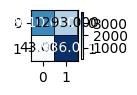

In [ ]:
kmeans = km_train(X_tfidf, 2)
matrix = contingency_matrix(dataset['label'], kmeans.labels_)
print("Contingency Matrix: \n", matrix)
plot_mat(matrix)

# END OF QUESTION 2
***

# QUESTION 3
### Report the 5 clustering measures explained in the introduction for Kmeans clustering.

In [ ]:
evaluate(dataset['label'], kmeans.labels_)

Homogeneity: 0.4244
Completeness: 0.4605
V-measure: 0.4417
Adjusted Rand Index: 0.4369
Adjusted Mutual Information Score: 0.4417
Average Score:0.4410


# END OF QUESTION 3
***

# QUESTION 4
### Report the plot of the percentage of variance that the top r principle components retain v.s. r, for r = 1 to 1000.

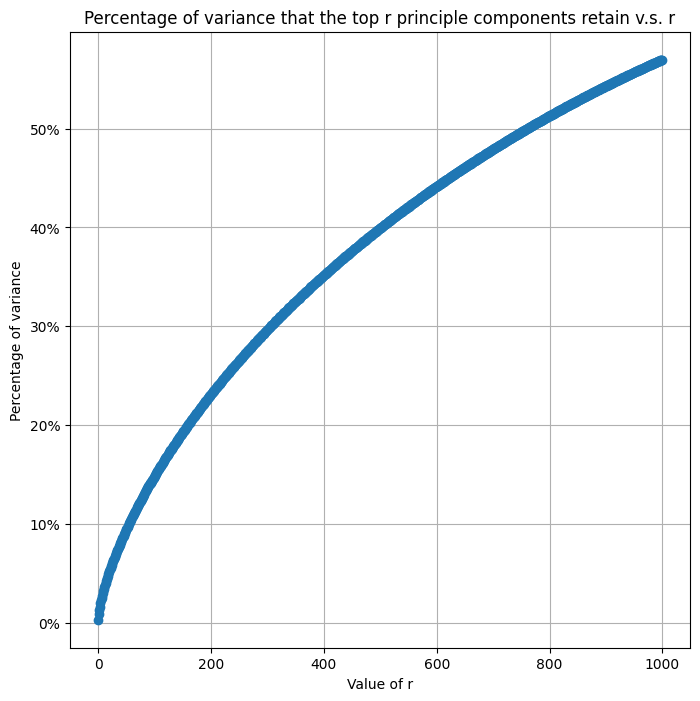

In [ ]:
svd_1000 = TruncatedSVD(n_components=1000, random_state=SEED)
X_reduced = svd_1000.fit_transform(X_tfidf)

plt.plot(np.arange(1000), svd_1000.explained_variance_ratio_.cumsum(), marker='o')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xlabel("Value of r")
plt.ylabel("Percentage of variance")
plt.title("Percentage of variance that the top r principle components retain v.s. r")
plt.grid()
plt.show()

# END OF QUESTION 4
***

# QUESTION 5 - 7

In [ ]:
def get_score_row(r, reduction_type, truth_labels, pred_labels):
    scores = [
        metrics.homogeneity_score(truth_labels, pred_labels),
        metrics.completeness_score(truth_labels, pred_labels),
        metrics.v_measure_score(truth_labels, pred_labels),
        metrics.adjusted_rand_score(truth_labels, pred_labels),
        metrics.adjusted_mutual_info_score(truth_labels, pred_labels)
    ]
    
    new_row = pd.DataFrame({
        'r': r,
        'Reduction': reduction_type,
        'Average_score': np.mean(scores),
        'Homogeneity': scores[0],
        'Completeness': scores[1],
        'V-measure': scores[2],
        'Adjusted_rand_index': scores[3],
        'Adjusted_mutual_info_score': scores[4]
    }, index=[0])
    
    return new_row, np.mean(scores)

In [ ]:
#r_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
r_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]
svd_nmf_scores = pd.DataFrame(columns=['r', 'Reduction', 'Average_score', 'Homogeneity', 'Completeness', 'V-measure', 'Adjusted_rand_index', 'Adjusted_mutual_info_score'])

best_svd_kmeans = {'model': None, 'x': None, 'avg_score': 0, 'r': 0}
best_nmf_kmeans = {'model': None, 'x': None, 'avg_score': 0, 'r': 0}

for r in r_options:
    time_start = time()
    ################################################################################
    # SVD
    ################################################################################
    svd = TruncatedSVD(n_components=r, random_state=SEED)
    X_tfidf_svd = svd.fit_transform(X_tfidf)
    
    kmeans_svd = km_train(X_tfidf_svd, 2)
    new_row, avg_score = get_score_row(r, 'svd', dataset['label'], kmeans_svd.labels_)
    svd_nmf_scores = pd.concat([svd_nmf_scores, new_row], ignore_index=True)
    if avg_score > best_svd_kmeans['avg_score']:
        best_svd_kmeans['model'] = kmeans_svd
        best_svd_kmeans['x'] = X_tfidf_svd
        best_svd_kmeans['avg_score'] = avg_score
        best_svd_kmeans['r'] = r
    
    ################################################################################
    # NMF
    ################################################################################
    nmf = NMF(n_components=r, random_state=SEED)
    X_tfidf_nmf = nmf.fit_transform(X_tfidf)
    
    kmeans_nmf = km_train(X_tfidf_nmf, 2)
    new_row, avg_score = get_score_row( r, 'nmf', dataset['label'], kmeans_nmf.labels_)
    svd_nmf_scores = pd.concat([svd_nmf_scores, new_row], ignore_index=True)
    if avg_score > best_nmf_kmeans['avg_score']:
        best_nmf_kmeans['model'] = kmeans_nmf
        best_nmf_kmeans['x'] = X_tfidf_nmf
        best_nmf_kmeans['avg_score'] = avg_score
        best_nmf_kmeans['r'] = r
    
    print(f"Clustering({r}) done in {(time() - time_start):.2f}s")

print('='*100)
print(f'SVD - Best model at r:{best_svd_kmeans["r"]} with average score:{best_svd_kmeans["avg_score"]}')
print(f'NMF - Best model at r:{best_nmf_kmeans["r"]} with average score:{best_nmf_kmeans["avg_score"]}')

Clustering(1) done in 0.40s
Clustering(2) done in 0.88s
Clustering(3) done in 0.81s
Clustering(4) done in 0.77s
Clustering(5) done in 0.91s
Clustering(6) done in 0.76s
Clustering(7) done in 0.81s
Clustering(8) done in 0.81s
Clustering(9) done in 0.87s
Clustering(10) done in 1.98s
Clustering(20) done in 3.27s
SVD - Best model at r:20 with average score:0.4399256983056235
NMF - Best model at r:2 with average score:0.470729002085409


r Reduction  Average_score  Homogeneity  Completeness  V-measure   
0    1       svd       0.056217     0.052247      0.052974   0.052608  \
1    1       nmf       0.056217     0.052247      0.052974   0.052608   
2    2       svd       0.434880     0.417746      0.450322   0.433423   
3    2       nmf       0.470729     0.450792      0.454041   0.452411   
4    3       svd       0.428106     0.410941      0.443731   0.426707   
5    3       nmf       0.062476     0.040136      0.137579   0.062143   
6    4       svd       0.402909     0.386814      0.434298   0.409183   
7    4       nmf       0.060279     0.038397      0.133834   0.059674   
8    5       svd       0.416589     0.400221      0.442118   0.420127   
9    5       nmf       0.364535     0.347331      0.378383   0.362192   
10   6       svd       0.431624     0.414724      0.449651   0.431482   
11   6       nmf       0.153376     0.130614      0.232368   0.167229   
12   7       svd       0.433274     0.416388      0.451274   0.433130   
13   7       nmf       0.396428     0.378938      0.408645   0.393231   
14   8       svd       0.436223     0.419395      0.454473   0.436230   
15   8       nmf       0.390239     0.372722      0.401633   0.386638   
16   9       svd       0.439020     0.422175      0.456818   0.438814   
17   9       nmf       0.376670     0.359361      0.390256   0.374172   
18  10       svd       0.439203     0.422438      0.457709   0.439367   
19  10       nmf       0.179224     0.158235      0.263364   0.197692   
20  20       svd       0.439926     0.423240      0.459070   0.440428   
21  20       nmf       0.444838     0.426246      0.446207   0.435998   

    Adjusted_rand_index  Adjusted_mutual_info_score  
0              0.070732                    0.052521  
1              0.070732                    0.052521  
2              0.439539                    0.433369  
3              0.544040                    0.452361  
4              0.432501                    0.426652  
5              0.010515                    0.062010  
6              0.375123                    0.409126  
7              0.009947                    0.059540  
8              0.400406                    0.420072  
9              0.372639                    0.362132  
10             0.430833                    0.431428  
11             0.069538                    0.167131  
12             0.432501                    0.433076  
13             0.408151                    0.393173  
14             0.434841                    0.436176  
15             0.403624                    0.386580  
16             0.438530                    0.438760  
17             0.385452                    0.374112  
18             0.437187                    0.439313  
19             0.079228                    0.197600  
20             0.436516                    0.440374  
21             0.479793                    0.435945

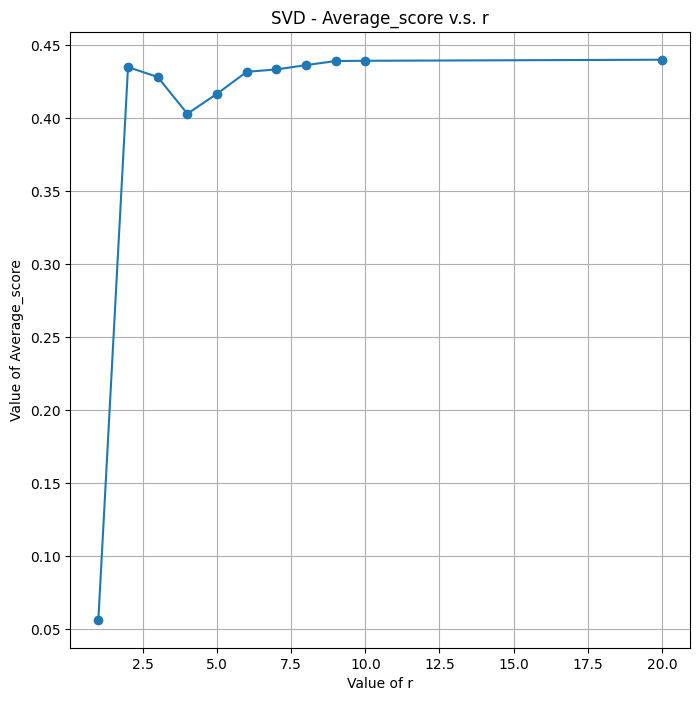

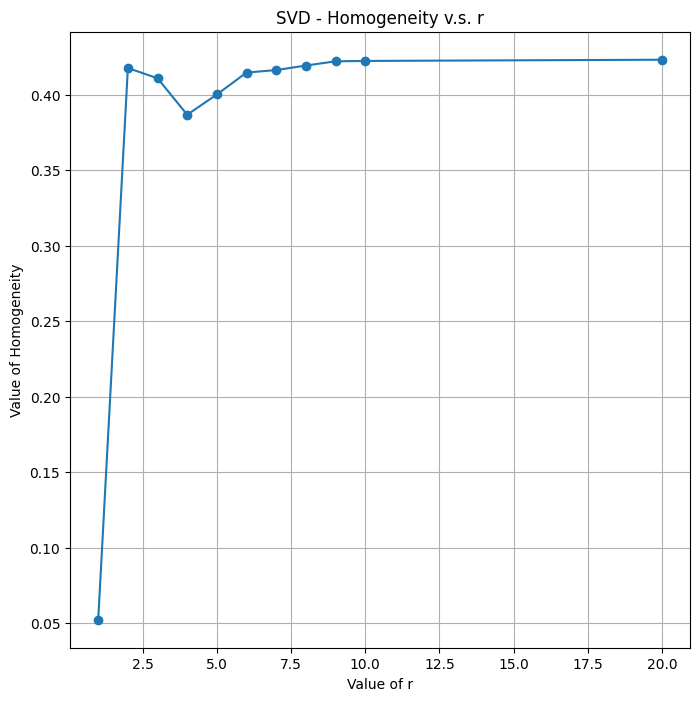

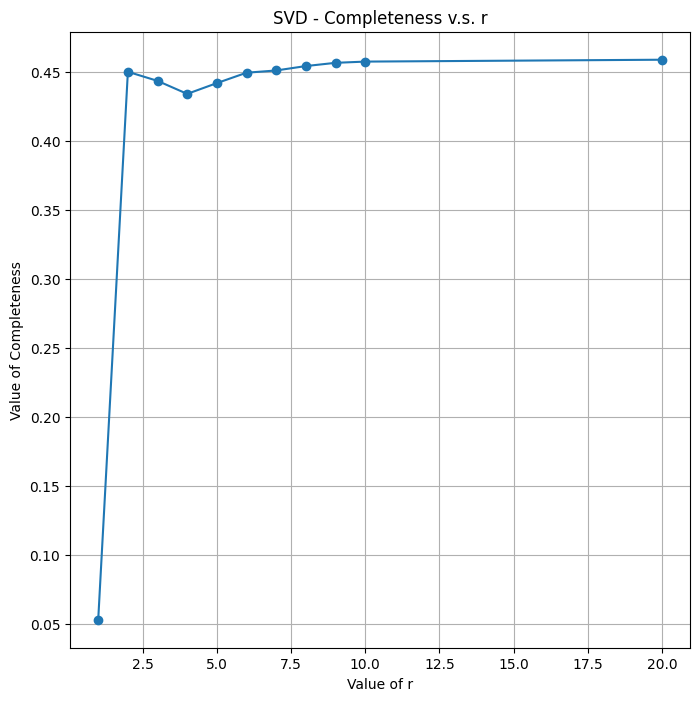

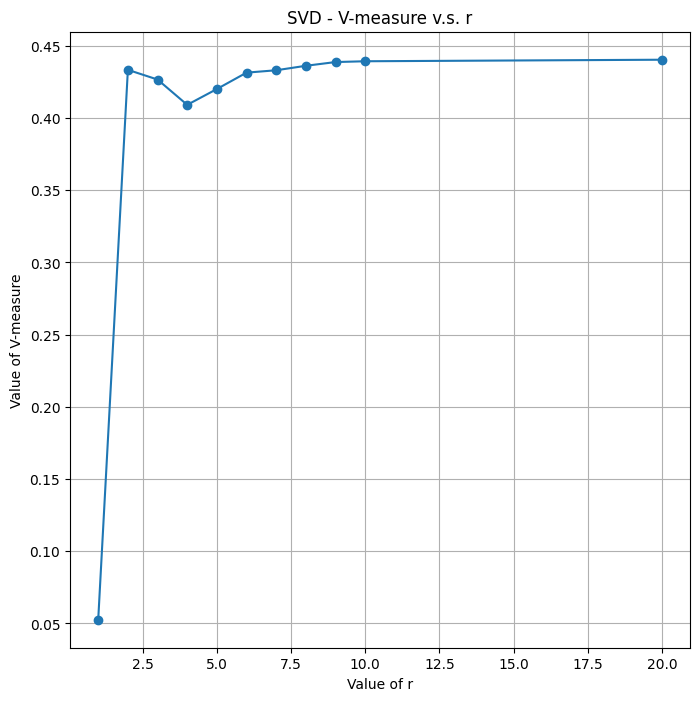

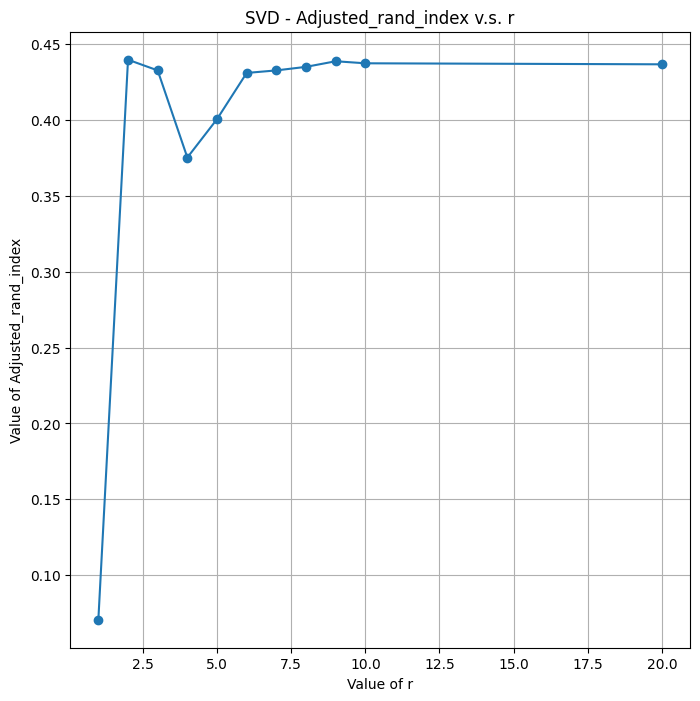

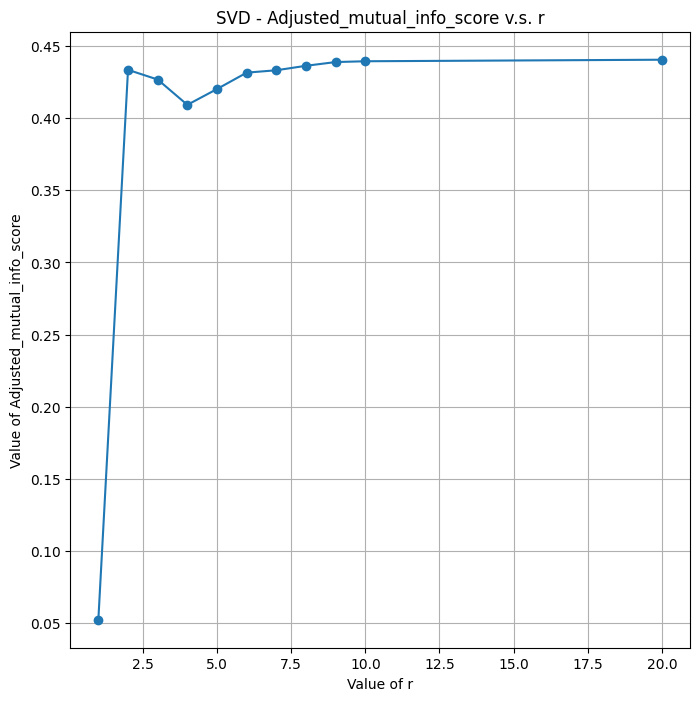

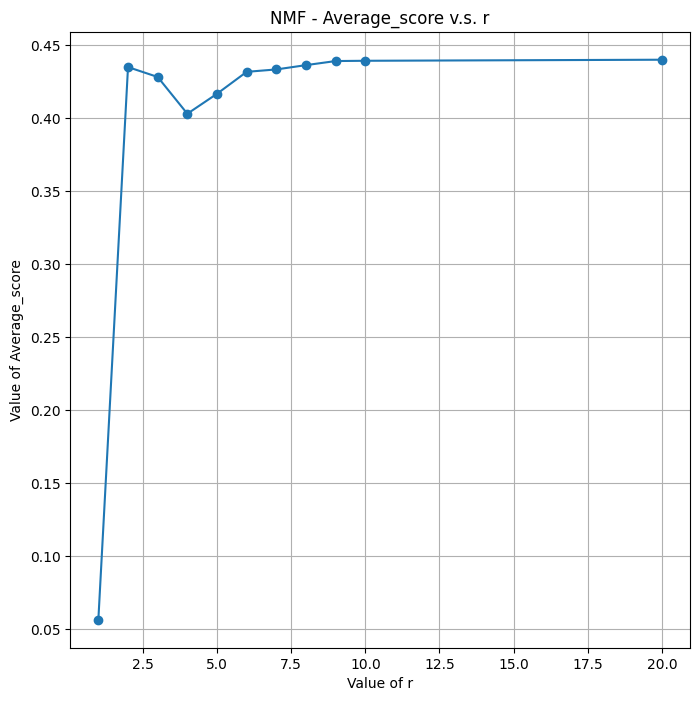

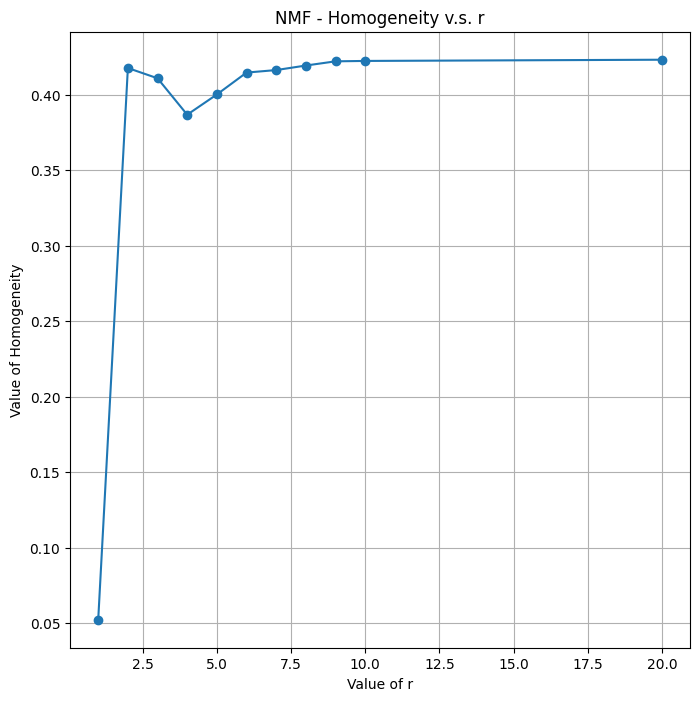

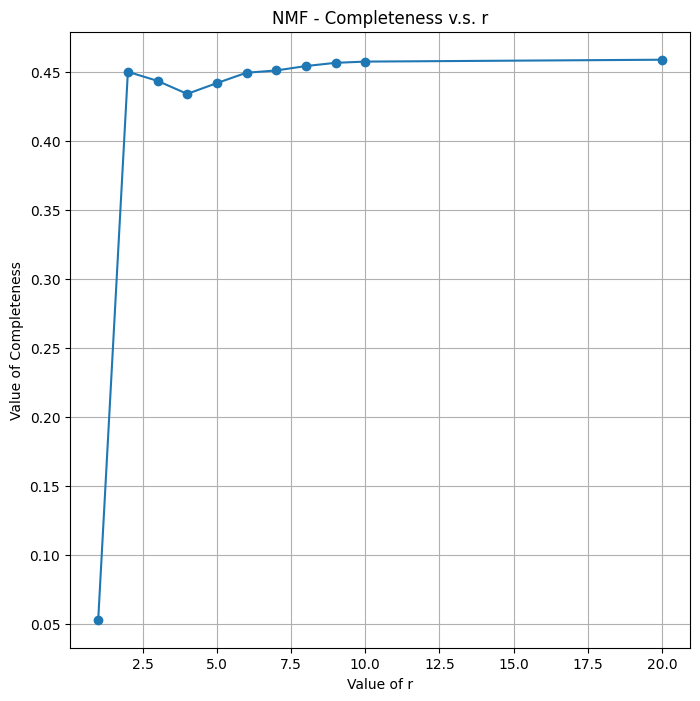

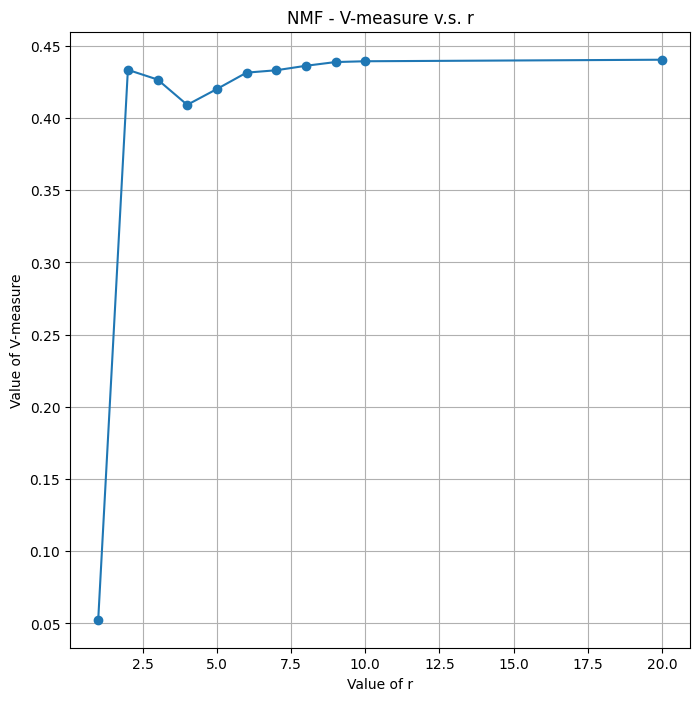

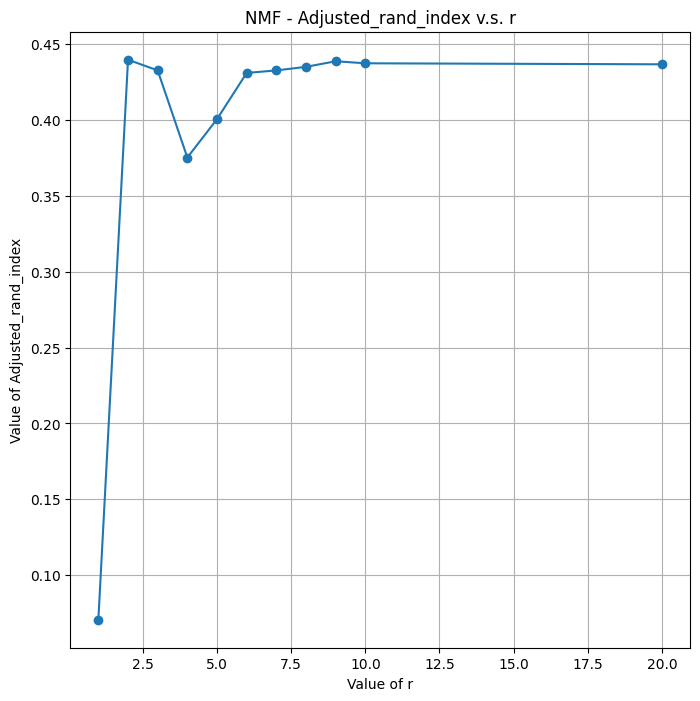

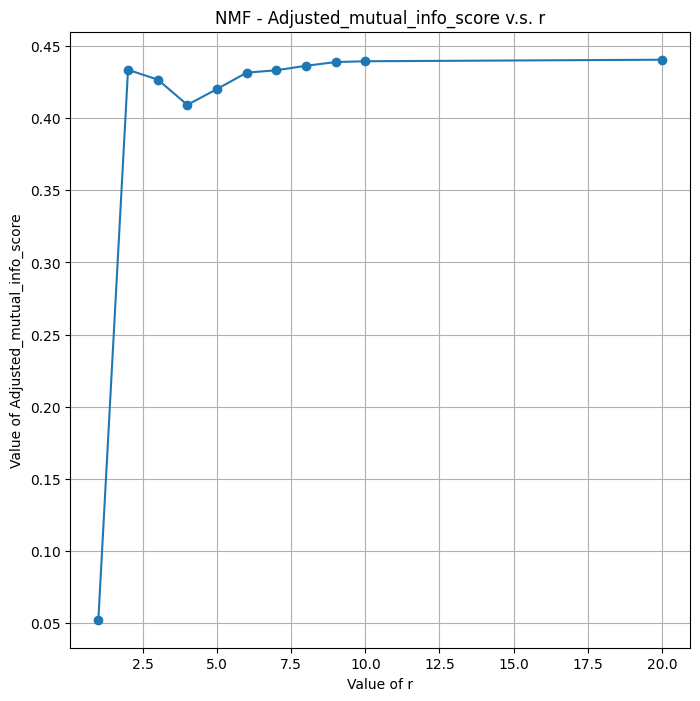

In [ ]:
# svd_nmf_scores['average_score'] = svd_nmf_scores.iloc[:, 2:7].mean(axis=1)
display(svd_nmf_scores)

for re in ['svd', 'nmf']:
    for i in range(2, 8):
        plt.plot(r_options, svd_nmf_scores.loc[(svd_nmf_scores['Reduction'] == 'svd')][svd_nmf_scores.columns[i]], marker='o')
        plt.xlabel('Value of r')
        plt.ylabel('Value of '+svd_nmf_scores.columns[i])
        plt.title(re.upper()+' - '+svd_nmf_scores.columns[i]+' v.s. r')
        plt.grid()
        plt.show()
    print('='*100+'\n'+'='*100+'\n'+'='*100)


# QUESTION 5
### Let r be the dimension that we want to reduce the data to (i.e. n components).
### Try r = 1 − 10, 20, 50, 100, 300, and plot the 5 measure scores v.s. r for both SVD and NMF. Report a good choice of r for SVD and NMF respectively.
#### Note: In the choice of r, there is a trade-off between the information preservation, and better performance of k-means in lower dimensions.
***
`Based on the average score for SVD and NMF in last 2 charts below, a good choice of them should be r = 20 and r = 2 respectively.`

***

# QUESTION 6
### How do you explain the non-monotonic behavior of the measures as r increases?
***
`Higher r means that more information is preserved for k-means clustering model training. However, noise is not removed and hence will affect the result and converging time of the model`

***

# QUESTION 7
### Are these measures on average better than those computed in Question 3?
***
`No`


# END OF QUESTION 5 - 7
***

# QUESTION 8
### Visualize the clustering results for:
### • SVD with your optimal choice of r for K-Means clustering;
### • NMF with your choice of r for K-Means clustering.
### To recap, you can accomplish this by first creating the dense representations and then once again projecting these representations into a 2-D plane for visualization.

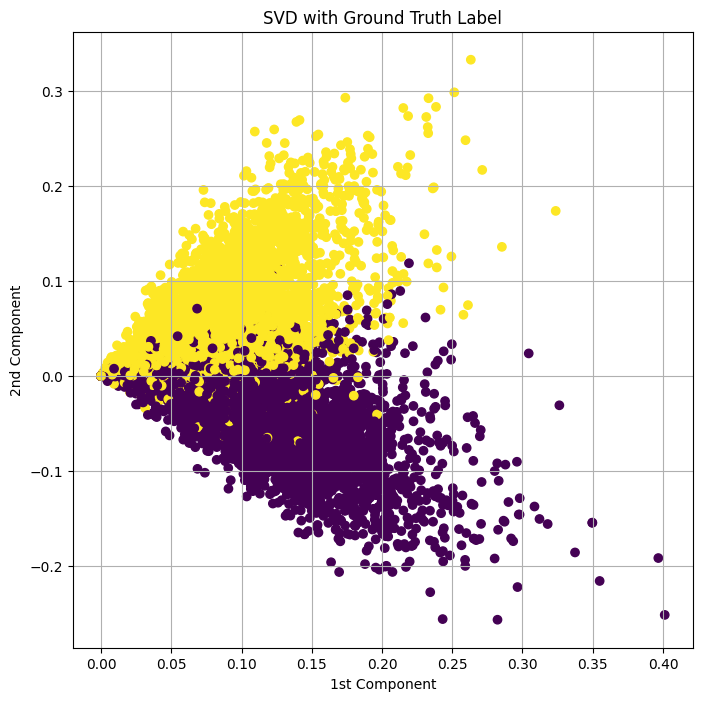

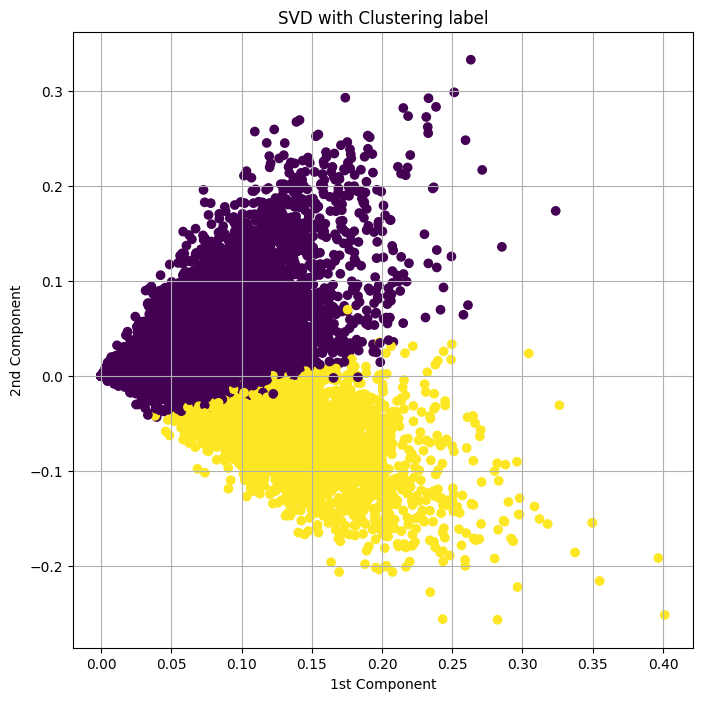

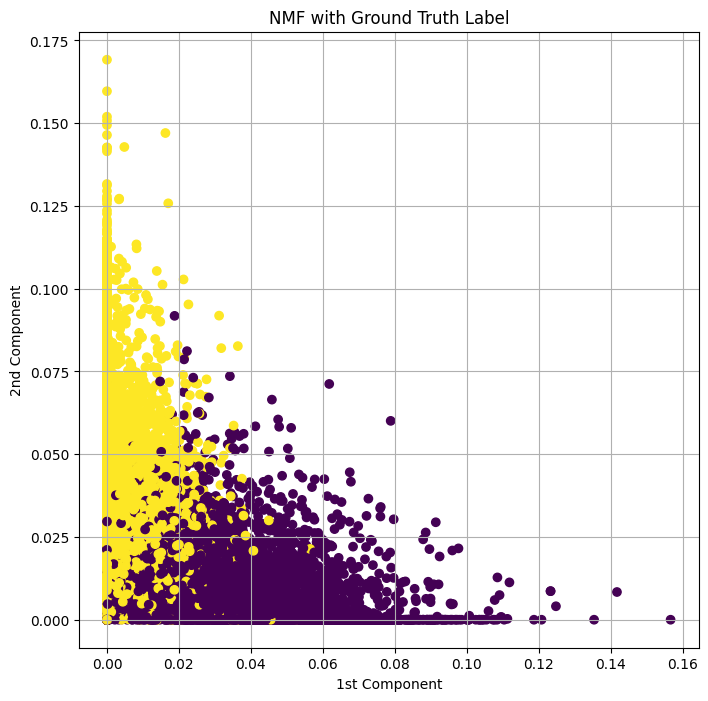

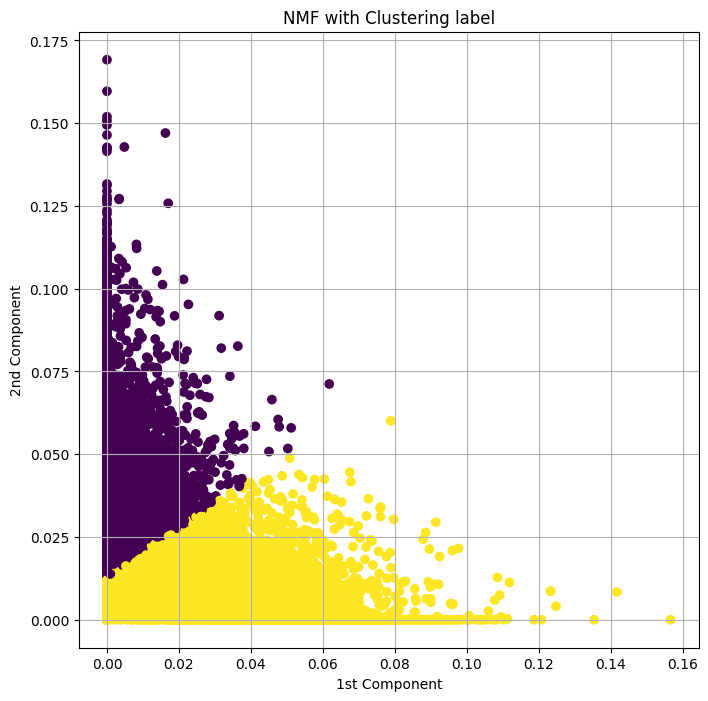

In [ ]:
plt.scatter(best_svd_kmeans['x'][:,0], best_svd_kmeans['x'][:,1], c=dataset['label'])
plt.xlabel('1st Component')
plt.ylabel('2nd Component')
plt.title('SVD with Ground Truth Label')
plt.grid()
plt.show()

plt.scatter(best_svd_kmeans['x'][:,0], best_svd_kmeans['x'][:,1], c=best_svd_kmeans['model'].labels_)
plt.xlabel('1st Component')
plt.ylabel('2nd Component')
plt.title('SVD with Clustering label')
plt.grid()
plt.show()

print('='*100+'\n'+'='*100+'\n'+'='*100)

plt.scatter(best_nmf_kmeans['x'][:,0], best_nmf_kmeans['x'][:,1], c=dataset['label'])
plt.xlabel('1st Component')
plt.ylabel('2nd Component')
plt.title('NMF with Ground Truth Label')
plt.grid()
plt.show()

plt.scatter(best_nmf_kmeans['x'][:,0], best_nmf_kmeans['x'][:,1], c=best_nmf_kmeans['model'].labels_)
plt.xlabel('1st Component')
plt.ylabel('2nd Component')
plt.title('NMF with Clustering label')
plt.grid()
plt.show()

# Question 9

From the images above, we can see that the result of classifying works quite well. Both SVD and NMF generate a good classification result. Based on the results, We are confident to say that the data is ideal for K-Means clustering.

# Question 10

### SVD

In [ ]:
dataset = fetch_20newsgroups(subset='all', shuffle=True, random_state=SEED, remove=('headers', 'footers'))
tfidf_vect = TfidfVectorizer(stop_words='english',min_df=3)

tfidf_transformer = TfidfTransformer()
data_feat_vec = tfidf_vect.fit_transform(dataset.data)
data_feat = tfidf_transformer.fit_transform(data_feat_vec)

Working on r = 1
Running SVD


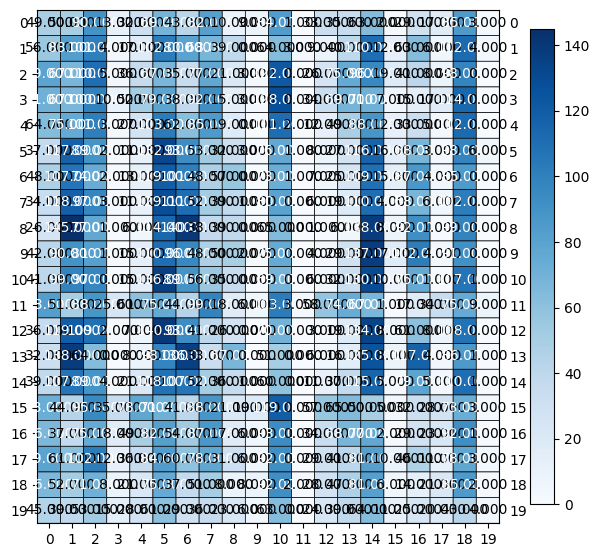

Running NMF


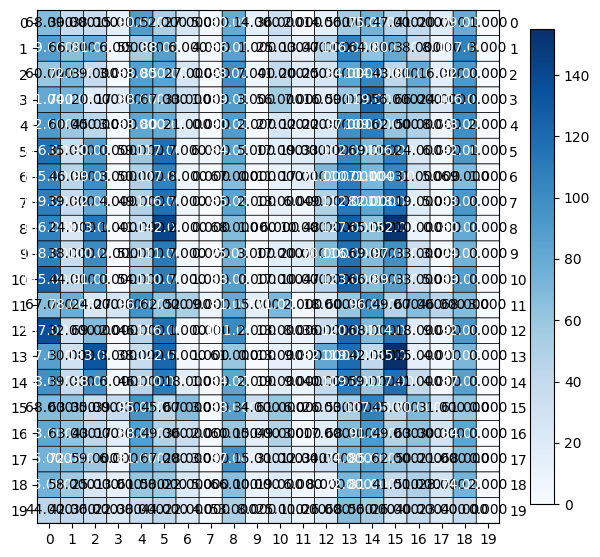

Working on r = 2
Running SVD


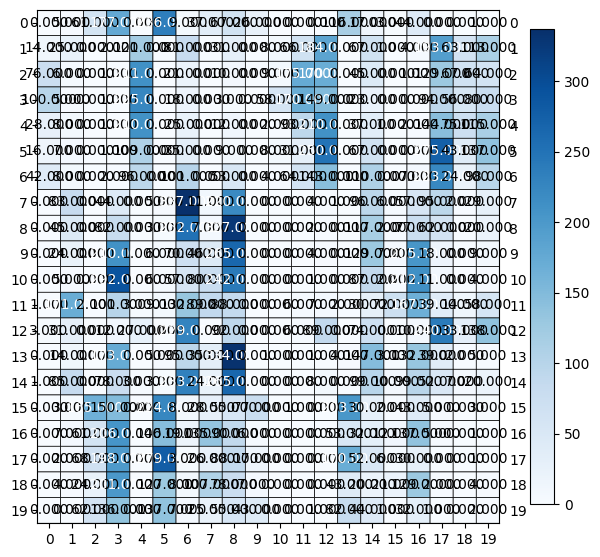

Running NMF


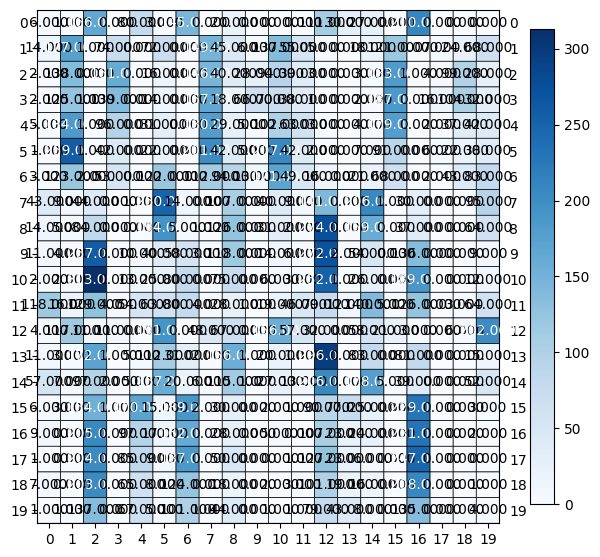

Working on r = 3
Running SVD


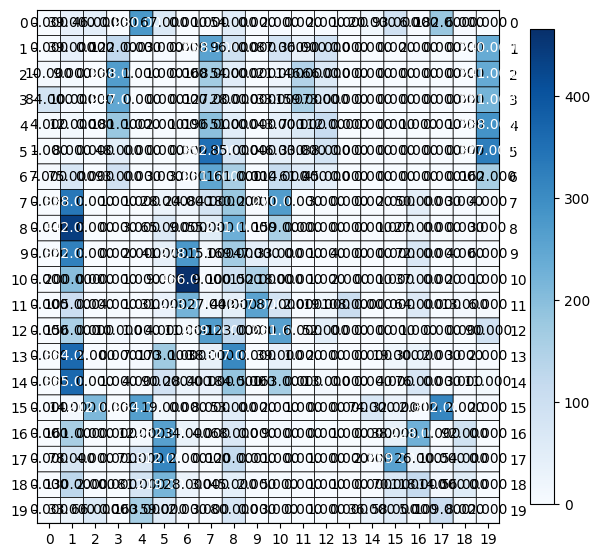

Running NMF


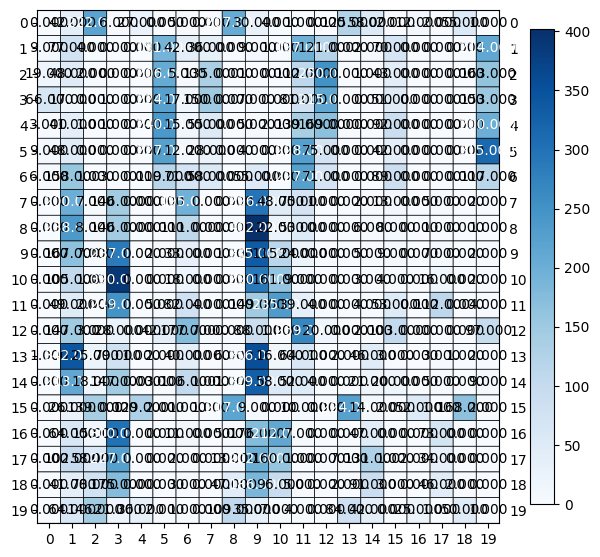

Working on r = 5
Running SVD


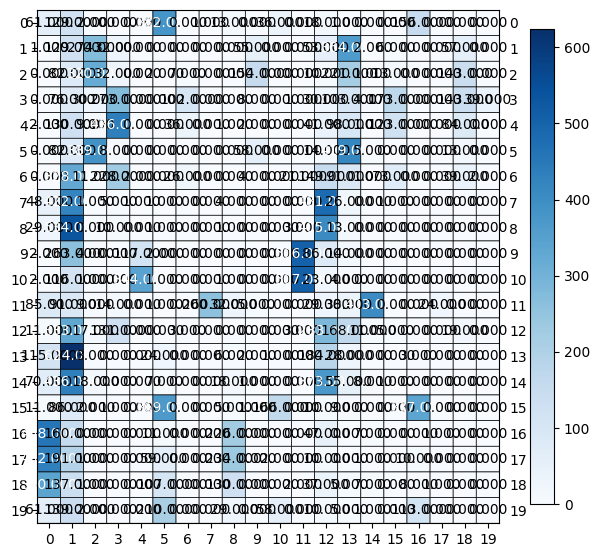

Running NMF


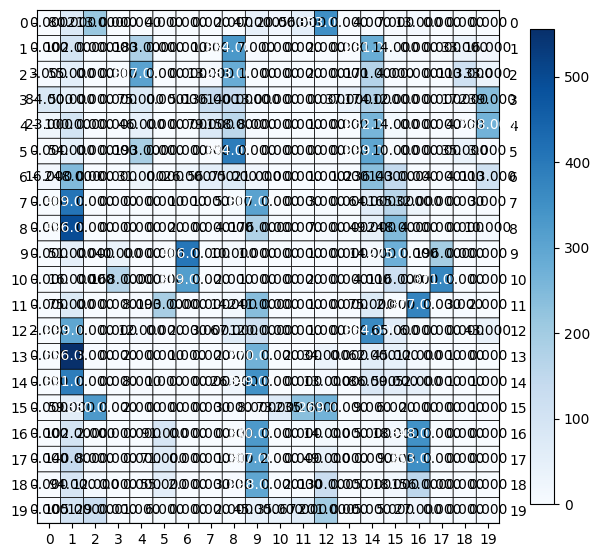

Working on r = 10
Running SVD


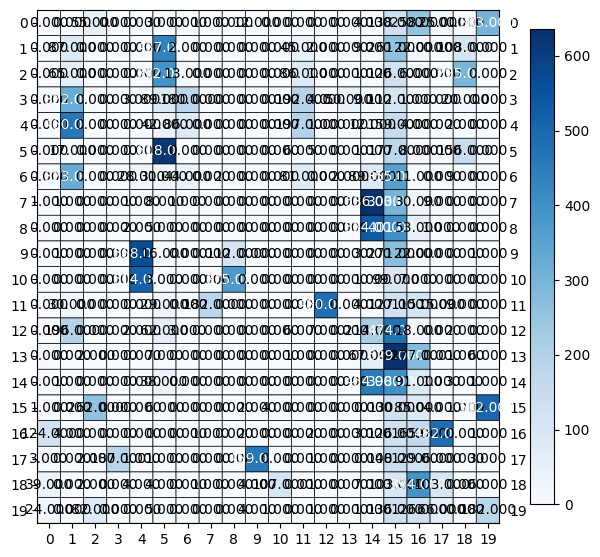

Running NMF


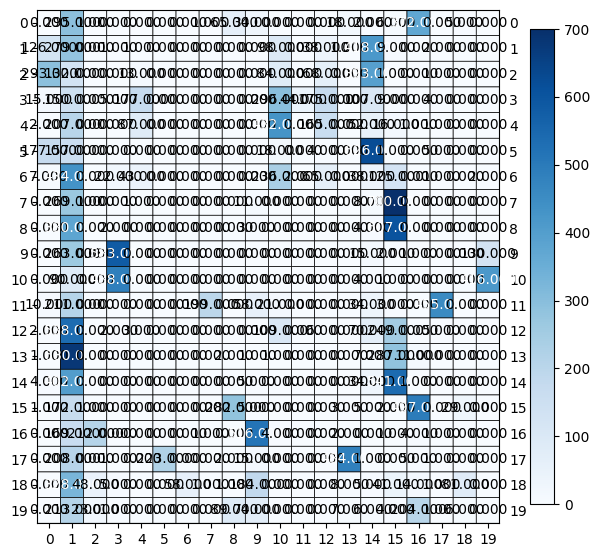

Working on r = 20
Running SVD


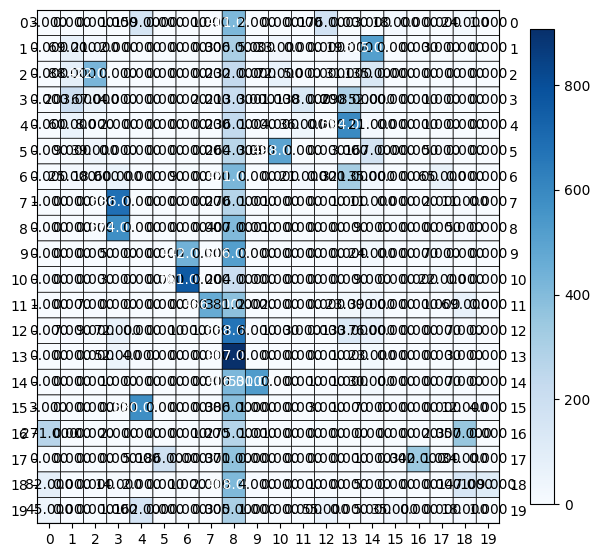

Running NMF


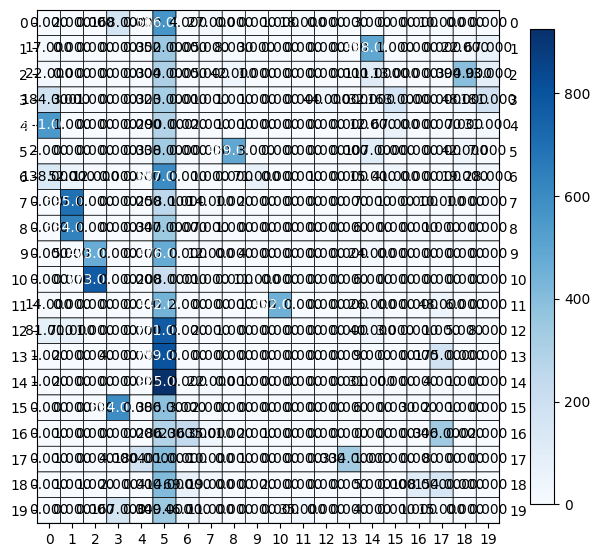

Working on r = 50
Running SVD


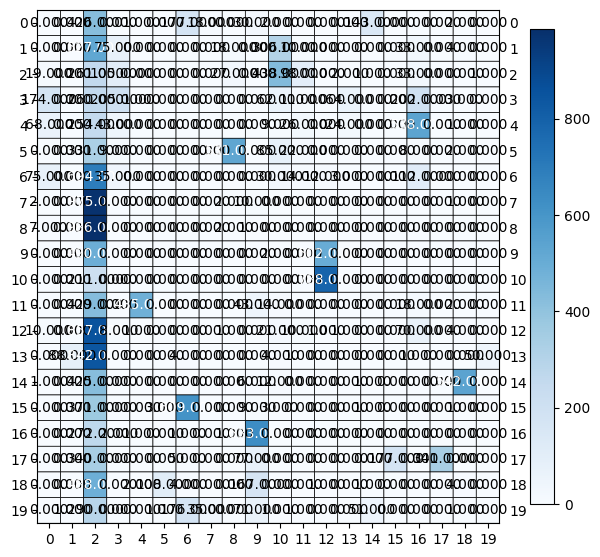

Running NMF


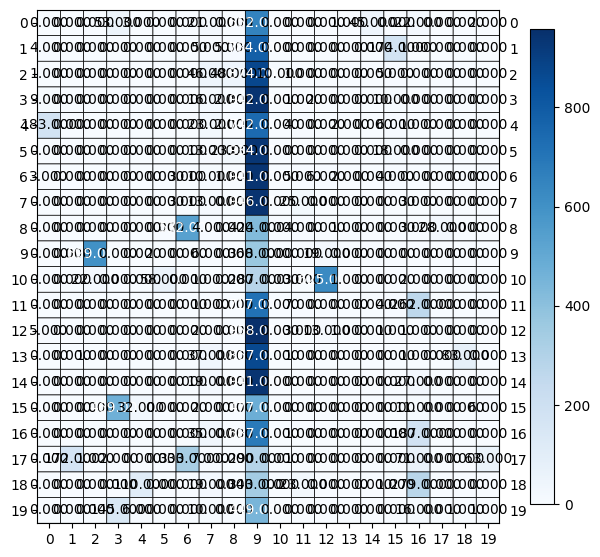

Working on r = 100
Running SVD


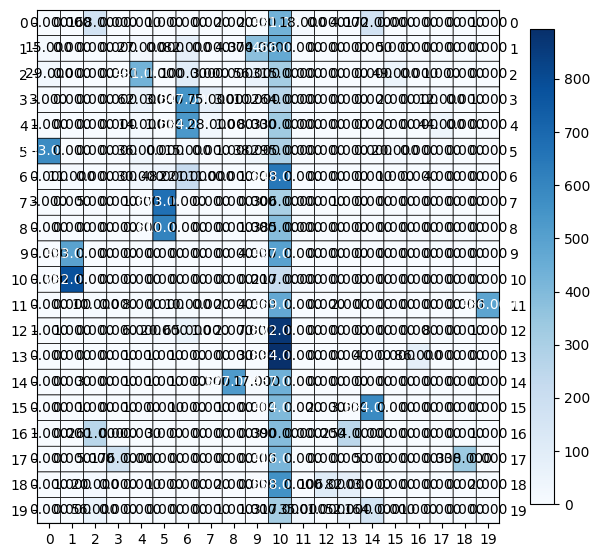

Running NMF


/Users/cwhuang/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


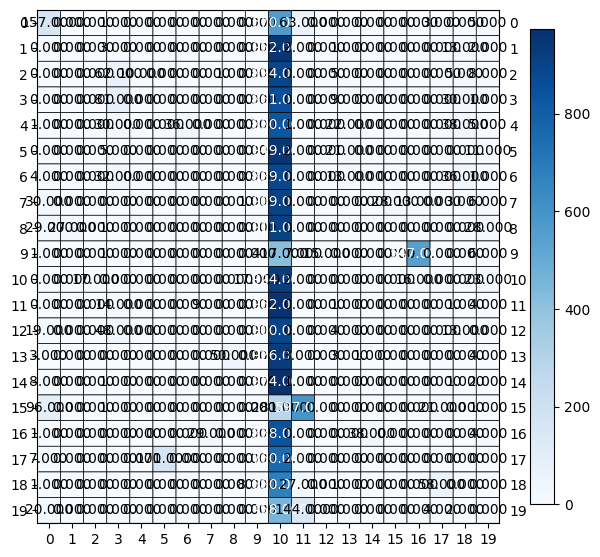

In [ ]:
svd_hs, svd_cs, svd_vs, svd_ari, svd_ms = [], [], [], [], []
nmf_hs, nmf_cs, nmf_vs, nmf_ari, nmf_ms = [], [], [], [], []

r = [1, 2, 3, 5, 10, 20, 50, 100]
km = KMeans(n_clusters=20, random_state=SEED, max_iter=1000, n_init=30)
for i in range(len(r)):
    print(f'Working on r = {r[i]}')
    ################################################################################
    # SVD
    ################################################################################
    print('Running SVD')
    svd = TruncatedSVD(n_components=r[i], random_state=0)
    svd_km = svd.fit_transform(data_feat)
    kmean_svd = km.fit(svd_km)
    
    svd_hs.append(homogeneity_score(dataset.target, kmean_svd.labels_))
    svd_cs.append(completeness_score(dataset.target, kmean_svd.labels_))
    svd_vs.append(v_measure_score(dataset.target, kmean_svd.labels_))
    svd_ari.append(adjusted_rand_score(dataset.target, kmean_svd.labels_))
    svd_ms.append(adjusted_mutual_info_score(dataset.target, kmean_svd.labels_))
    matrix = contingency_matrix(dataset.target, kmean_svd.labels_)
    plot_mat(matrix)
    ################################################################################
    # NMF
    ################################################################################
    print('Running NMF')
    nmf = NMF(n_components=r[i], random_state=SEED)
    nmf_km = nmf.fit_transform(data_feat)
    kmean_nmf = km.fit(nmf_km)
    
    nmf_hs.append(homogeneity_score(dataset.target, kmean_nmf.labels_))
    nmf_cs.append(completeness_score(dataset.target, kmean_nmf.labels_))
    nmf_vs.append(v_measure_score(dataset.target, kmean_nmf.labels_))
    nmf_ari.append(adjusted_rand_score(dataset.target, kmean_nmf.labels_))
    nmf_ms.append(adjusted_mutual_info_score(dataset.target, kmean_nmf.labels_))
    matrix = contingency_matrix(dataset.target, kmean_nmf.labels_)
    plot_mat(matrix)

In [ ]:
print('SVD result:')
print('Homogeneity: ', svd_hs)
print('Completeness: ', svd_cs) 
print('V-measure: ', svd_vs) 
print('Adjusted Rand-Index: ', svd_ari) 
print('Adjusted Mutual Information Score: ', svd_ms)

avg_metrics = [y/5 for y in [sum(x) for x in zip(svd_hs, svd_cs, svd_vs, svd_ari, svd_ms)]]
best_r_SVD = r[avg_metrics.index(max(avg_metrics))]
print('Best value of r for SVD (according to average metric): ', best_r_SVD, ', avg. value of 5 metrics: ',max(avg_metrics))

SVD result:
Homogeneity:  [0.025929413284785336, 0.2390926141336842, 0.2997612532593339, 0.3671996248455497, 0.4131740313140059, 0.3934166404105422, 0.351720846766791, 0.38244608208502057]
Completeness:  [0.0290763061622833, 0.25965251791121635, 0.3321120437284463, 0.4315442975313402, 0.48783855439947393, 0.5185579876312899, 0.5380957428990246, 0.5573487593980531]
V-measure:  [0.027412842404590087, 0.24894879282028565, 0.3151084969887026, 0.39678024387639255, 0.4474126673647242, 0.4474013532371992, 0.425389889404354, 0.45362208851956387]
Adjusted Rand-Index:  [0.005767663165622813, 0.0772821560760135, 0.10653685044559436, 0.13737735169586682, 0.1612537954769802, 0.10851879120726676, 0.07809788879410304, 0.0900432240968862]
Adjusted Mutual Information Score:  [0.024031295266971866, 0.24641032921052605, 0.3127694277113276, 0.3946359116798083, 0.445459104843614, 0.4453459018409993, 0.4230942324310317, 0.4514830406377971]
Best value of r for SVD (according to average metric):  10 , avg. va

In [ ]:
print('NMF result:')
print('Homogeneity: ', nmf_hs)
print('Completeness: ', nmf_cs) 
print('V-measure: ', nmf_vs) 
print('Adjusted Rand-Index: ', nmf_ari) 
print('Adjusted Mutual Information Score: ', nmf_ms)

avg_metrics = [y/5 for y in [sum(x) for x in zip(nmf_hs, nmf_cs, nmf_vs, nmf_ari, nmf_ms)]]
best_r_SVD = r[avg_metrics.index(max(avg_metrics))]
print('Best value of r for NMF (according to average metric): ', best_r_SVD, ', avg. value of 5 metrics: ', max(avg_metrics))

NMF result:
Homogeneity:  [0.026388617282757716, 0.22403330349175413, 0.27301858222721764, 0.34517298833065324, 0.4079026722356775, 0.3597957506819032, 0.21415971031690015, 0.1139727789934489]
Completeness:  [0.02916780038572191, 0.24241429612668322, 0.3037136132881612, 0.39685872522231713, 0.503833597584384, 0.5145491332284905, 0.5087899219161481, 0.43344751282694693]
V-measure:  [0.027708695184476682, 0.23286163598790016, 0.2875492672259811, 0.36921578856562454, 0.450821312301956, 0.42347726866013313, 0.30143815677216007, 0.18048734518191328]
Adjusted Rand-Index:  [0.0059955126412535, 0.07027513555097571, 0.08850496132521804, 0.12675886968034222, 0.1426836403449502, 0.08557144509291083, 0.028145810745997164, 0.011155233668442012]
Adjusted Mutual Information Score:  [0.024364564657205334, 0.23026048170795907, 0.28511112401832756, 0.3670092648090964, 0.44882977817662223, 0.4212414759025987, 0.2981410563608866, 0.1759443603059813]
Best value of r for NMF (according to average metric):  

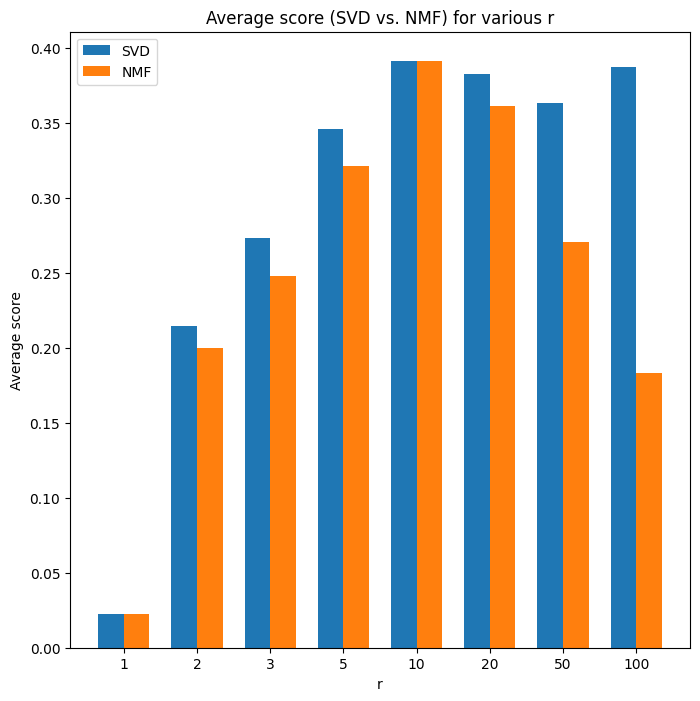

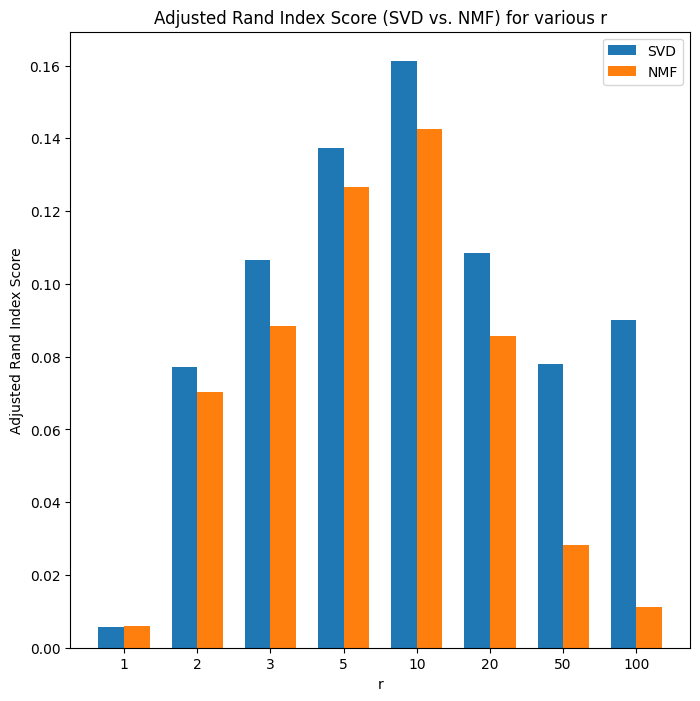

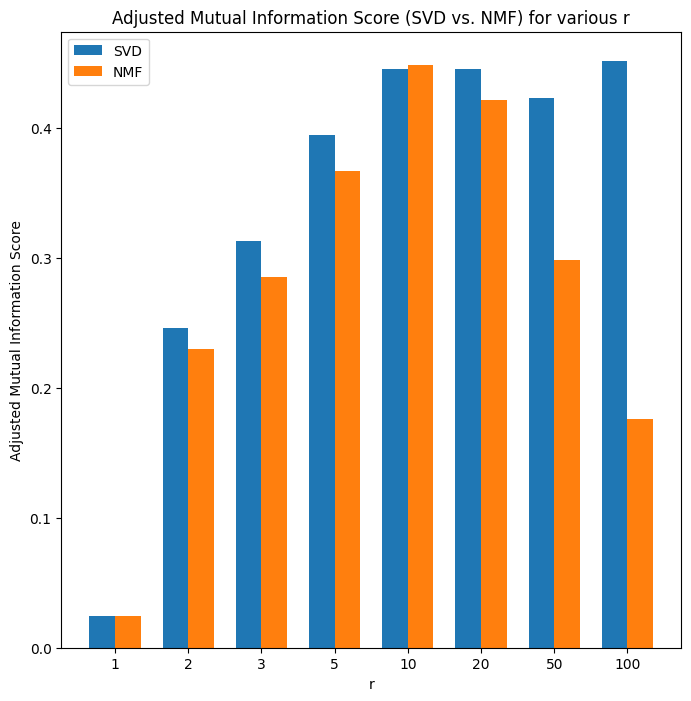

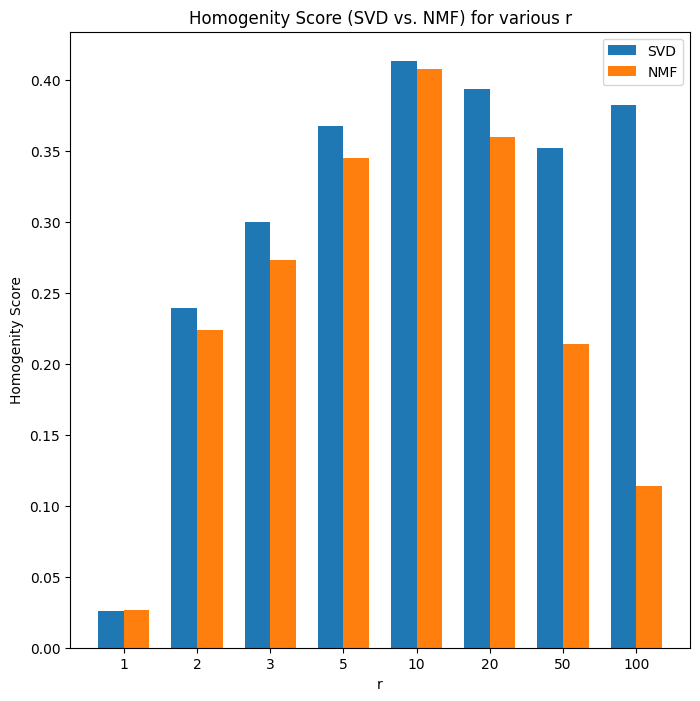

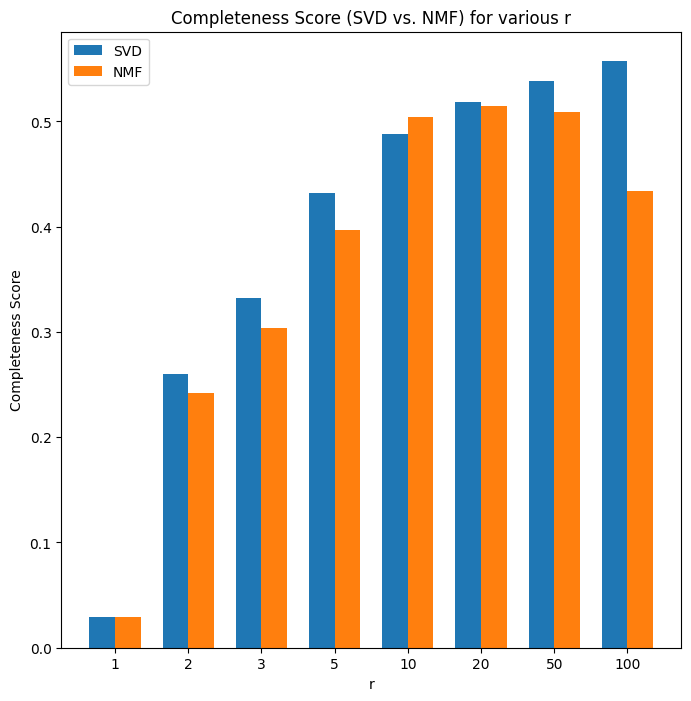

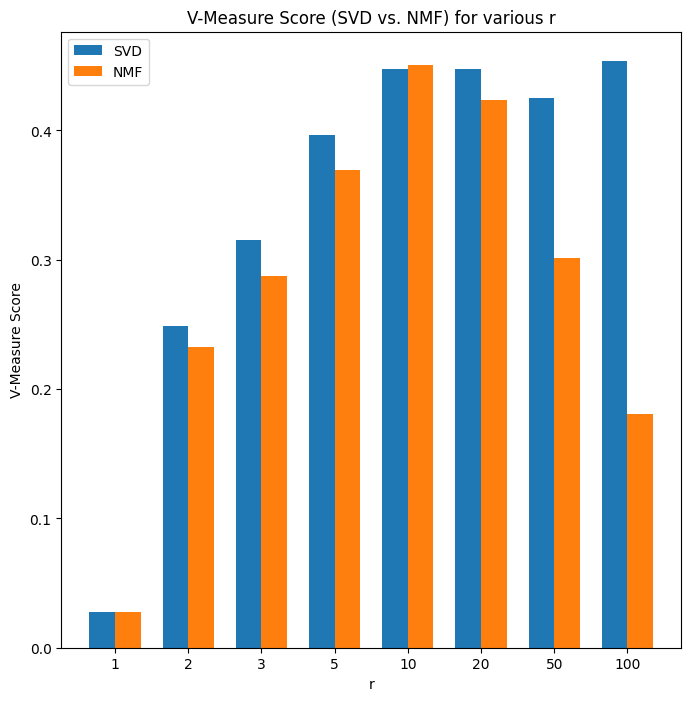

In [ ]:
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, [y/5 for y in [sum(x) for x in zip(svd_hs, svd_cs, svd_vs, svd_ari, svd_ms)]], width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, [y/5 for y in [sum(x) for x in zip(nmf_hs, nmf_cs, nmf_vs, nmf_ari, nmf_ms)]], width, label='NMF')
ax.set_ylabel('Average score')
ax.set_title('Average score (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_ari, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_ari, width, label='NMF')
ax.set_ylabel('Adjusted Rand Index Score')
ax.set_title('Adjusted Rand Index Score (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_ms, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_ms, width, label='NMF')
ax.set_ylabel('Adjusted Mutual Information Score')
ax.set_title('Adjusted Mutual Information Score (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_hs, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_hs, width, label='NMF')
ax.set_ylabel('Homogenity Score')
ax.set_title('Homogenity Score (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_cs, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_cs, width, label='NMF')
ax.set_ylabel('Completeness Score')
ax.set_title('Completeness Score (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(r)) - width/2, svd_vs, width, label='SVD')
rects2 = ax.bar(np.arange(len(r)) + width/2, nmf_vs, width, label='NMF')
ax.set_ylabel('V-Measure Score')
ax.set_title('V-Measure Score (SVD vs. NMF) for various r')
ax.set_xticks(np.arange(len(r)))
ax.set_xticklabels(r)
ax.set_xlabel('r')
ax.legend()
plt.show()

# Question 11

In [ ]:
euc_hs = []
euc_cs = []
euc_vs = []
euc_ari = []
euc_ms = []
cos_hs = []
cos_cs = []
cos_vs = []
cos_ari = []
cos_ms = []
n_components_arr = [5, 20, 200]

for n_components in n_components_arr:
    print(f'Working on n = {n_components} components')
    
    print('UMAP (euclidean)')
    Umap_euc = umap.UMAP(n_components=n_components, metric='euclidean').fit_transform(data_feat)
    kmean_euc = km.fit(Umap_euc)
    euc_hs.append(homogeneity_score(dataset.target, kmean_euc.labels_))
    euc_cs.append(completeness_score(dataset.target, kmean_euc.labels_))
    euc_vs.append(v_measure_score(dataset.target, kmean_euc.labels_))
    euc_ari.append(adjusted_rand_score(dataset.target, kmean_euc.labels_))
    euc_ms.append(adjusted_mutual_info_score(dataset.target, kmean_euc.labels_)) 
    
    print('UMAP (cosine)')
    Umap_cos = umap.UMAP(n_components=n_components, metric='cosine').fit_transform(data_feat)
    kmean_cos = km.fit(Umap_cos)
    cos_hs.append(homogeneity_score(dataset.target, kmean_cos.labels_))
    cos_cs.append(completeness_score(dataset.target, kmean_cos.labels_))
    cos_vs.append(v_measure_score(dataset.target, kmean_cos.labels_))
    cos_ari.append(adjusted_rand_score(dataset.target, kmean_cos.labels_))
    cos_ms.append(adjusted_mutual_info_score(dataset.target, kmean_cos.labels_)) 

Working on n = 5 components
UMAP (euclidean)
UMAP (cosine)
Working on n = 20 components
UMAP (euclidean)
UMAP (cosine)
Working on n = 200 components
UMAP (euclidean)
UMAP (cosine)


# Question 12

In [ ]:
print('n_components: ', n_components_arr)

print('Homogeneity (UMAP (euclidean)): ', euc_hs)
print('Completeness (UMAP (euclidean)): ', euc_cs)
print('V-measure (UMAP (euclidean)): ', euc_vs)
print('Adjusted Rand-Index (UMAP (euclidean)): ', euc_ari)
print('Adjusted Mutual Information Score (UMAP (euclidean)): ', euc_ms)
print('Homogeneity (UMAP (cosine)): ', cos_hs)
print('Completeness (UMAP (cosine)): ', cos_cs)
print('V-measure (UMAP (cosine)): ', cos_vs)
print('Adjusted Rand-Index (UMAP (cosine)): ', cos_ari)
print('Adjusted Mutual Information Score (UMAP (cosine)): ', cos_ms)

avg_metrics = [y / 5 for y in [sum(x) for x in zip(euc_hs, euc_cs, euc_vs, euc_ari, euc_ms)]]
best_r_euc = r[avg_metrics.index(max(avg_metrics))]
print('Best value of r for Euclidean UMAP (according to avg. metric): ', best_r_euc, ', avg. value of 5 metrics: ', max(avg_metrics))
print('Metrics: ')
print('Homogeneity (UMAP (euclidean), best r): ', euc_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (UMAP (euclidean), best r): ', euc_cs[avg_metrics.index(max(avg_metrics))])
print('V-measure (UMAP (euclidean), best r): ', euc_vs[avg_metrics.index(max(avg_metrics))])
print('Adjusted Rand-Index (UMAP (euclidean), best r): ', euc_ari[avg_metrics.index(max(avg_metrics))])
print('Adjusted Mutual Information Score (UMAP (euclidean), best r): ', euc_ms[avg_metrics.index(max(avg_metrics))])
avg_metrics = [y / 5 for y in [sum(x) for x in zip(cos_hs, cos_cs, cos_vs, cos_ari, cos_ms)]]
best_r_cos = r[avg_metrics.index(max(avg_metrics))]
print('Best value of r for Cosine UMAP (according to avg. metric): ', best_r_cos, ', avg. value of 5 metrics: ', max(avg_metrics))
print('Metrics: ')
print('Homogeneity (UMAP (cosine), best r): ', cos_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (UMAP (cosine), best r): ', cos_cs[avg_metrics.index(max(avg_metrics))])
print('V-measure (UMAP (cosine), best r): ', cos_vs[avg_metrics.index(max(avg_metrics))])
print('Adjusted Rand-Index (UMAP (cosine), best r): ', cos_ari[avg_metrics.index(max(avg_metrics))])
print('Adjusted Mutual Information Score (UMAP (cosine), best r): ', cos_ms[avg_metrics.index(max(avg_metrics))])

n_components:  [5, 20, 200]
Homogeneity (UMAP (euclidean)):  [0.012941418188748492, 0.010702557154837075, 0.010211750026104676]
Completeness (UMAP (euclidean)):  [0.013579967911429418, 0.011391369814952654, 0.010751008082805259]
V-measure (UMAP (euclidean)):  [0.01325300593775637, 0.011036226079964899, 0.010474442962119081]
Adjusted Rand-Index (UMAP (euclidean)):  [0.0026659363509316707, 0.0027978556881916978, 0.002758327099094623]
Adjusted Mutual Information Score (UMAP (euclidean)):  [0.010000785677404787, 0.007810719839700086, 0.007202632039841341]
Homogeneity (UMAP (cosine)):  [0.6035443304802447, 0.6067130810267725, 0.599164879603229]
Completeness (UMAP (cosine)):  [0.6279324592813431, 0.6179251417752801, 0.6367761889230742]
V-measure (UMAP (cosine)):  [0.615496904001159, 0.6122677859140835, 0.6173982535028562]
Adjusted Rand-Index (UMAP (cosine)):  [0.4945576303562334, 0.49880843594166124, 0.48701398975406296]
Adjusted Mutual Information Score (UMAP (cosine)):  [0.6142212806317547

# Question 13

So far, we have attempted K-Means clustering with 4 different representation learning techniques (sparse TF-IDF representation, PCA-reduced, NMF-reduced, UMAP-reduced). Compare and contrast the clustering results across the 4 choices, and suggest an approach that is best for the K-Means clustering task on the 20-class text data. Choose any choice of clustering metrics for your comparison.

Given all the metrics shown, We regard UMAP is the best one among these four techniques.

# Question 14

In [ ]:
ac_w = AgglomerativeClustering(n_clusters=20, linkage='ward').fit(Umap_cos)
ac_s = AgglomerativeClustering(n_clusters=20, linkage='single').fit(Umap_cos)
print("Agglomerative Clustering, Ward - Homogeneity: %0.3f" % homogeneity_score(dataset.target, ac_w.labels_))
print("Agglomerative Clustering, Ward - Completeness: %0.3f" % completeness_score(dataset.target, ac_w.labels_))
print("Agglomerative Clustering, Ward - V-measure: %0.3f" % v_measure_score(dataset.target, ac_w.labels_))
print("Agglomerative Clustering, Ward - Adjusted Rand-Index: %.3f"% adjusted_rand_score(dataset.target, ac_w.labels_))
print("Agglomerative Clustering, Ward - Adjusted Mutual Information Score: %.3f"% adjusted_mutual_info_score(dataset.target, ac_w.labels_))
print()
print("Agglomerative Clustering, Single - Homogeneity: %0.3f" % homogeneity_score(dataset.target, ac_s.labels_))
print("Agglomerative Clustering, Single - Completeness: %0.3f" % completeness_score(dataset.target, ac_s.labels_))
print("Agglomerative Clustering, Single - V-measure: %0.3f" % v_measure_score(dataset.target, ac_s.labels_))
print("Agglomerative Clustering, Single - Adjusted Rand-Index: %.3f"% adjusted_rand_score(dataset.target, ac_s.labels_))
print("Agglomerative Clustering, Single - Adjusted Mutual Information Score: %.3f"% adjusted_mutual_info_score(dataset.target, ac_s.labels_))

Agglomerative Clustering, Ward - Homogeneity: 0.591
Agglomerative Clustering, Ward - Completeness: 0.623
Agglomerative Clustering, Ward - V-measure: 0.606
Agglomerative Clustering, Ward - Adjusted Rand-Index: 0.471
Agglomerative Clustering, Ward - Adjusted Mutual Information Score: 0.605

Agglomerative Clustering, Single - Homogeneity: 0.018
Agglomerative Clustering, Single - Completeness: 0.382
Agglomerative Clustering, Single - V-measure: 0.034
Agglomerative Clustering, Single - Adjusted Rand-Index: 0.001
Agglomerative Clustering, Single - Adjusted Mutual Information Score: 0.030


# Question 15

In [ ]:
eps_rec = []
min_samples_rec = []
db_hs = []
db_cs = []
db_vs = []
db_ari = []
db_ms = []

eps = [0.1, 0.5, 1.0, 5.0, 30.0]
min_samples = [5, 15, 60, 100, 500]
min_cluster_sizes = [20, 100, 200]

for i in range(len(eps)):
    for j in range(len(min_samples)):
        print(f'Running eps = {eps[i]}, and min_sample = {min_samples[j]}')
        dbs = DBSCAN(eps=eps[i],min_samples=min_samples[j],n_jobs=-1).fit_predict(Umap_cos)
        db_hs.append(homogeneity_score(dataset.target, dbs))
        db_cs.append(completeness_score(dataset.target, dbs))
        db_vs.append(v_measure_score(dataset.target, dbs))
        db_ari.append(adjusted_rand_score(dataset.target, dbs))
        db_ms.append(adjusted_mutual_info_score(dataset.target, dbs)) 
        eps_rec.append(eps[i])
        min_samples_rec.append(min_samples[j])

Running eps = 0.1, and min_sample = 5
Running eps = 0.1, and min_sample = 15
Running eps = 0.1, and min_sample = 60
Running eps = 0.1, and min_sample = 100
Running eps = 0.1, and min_sample = 500
Running eps = 0.5, and min_sample = 5
Running eps = 0.5, and min_sample = 15
Running eps = 0.5, and min_sample = 60
Running eps = 0.5, and min_sample = 100
Running eps = 0.5, and min_sample = 500
Running eps = 1.0, and min_sample = 5
Running eps = 1.0, and min_sample = 15
Running eps = 1.0, and min_sample = 60
Running eps = 1.0, and min_sample = 100
Running eps = 1.0, and min_sample = 500
Running eps = 5.0, and min_sample = 5
Running eps = 5.0, and min_sample = 15
Running eps = 5.0, and min_sample = 60
Running eps = 5.0, and min_sample = 100
Running eps = 5.0, and min_sample = 500
Running eps = 10.0, and min_sample = 5
Running eps = 10.0, and min_sample = 15
Running eps = 10.0, and min_sample = 60
Running eps = 10.0, and min_sample = 100
Running eps = 10.0, and min_sample = 500
Running eps = 3

In [ ]:
avg_metrics = [y/5 for y in [sum(x) for x in zip(db_hs, db_cs, db_vs, db_ari, db_ms)]]
best_eps_db = eps_rec[avg_metrics.index(max(avg_metrics))]
best_minSample_db = min_samples_rec[avg_metrics.index(max(avg_metrics))]
print('Best value of epsilon and minimum number of samples hyperparameters for DBSCAN: ', best_eps_db,'and',best_minSample_db, ' respectively, avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (DBSCAN, best hyperparameters): ',db_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (DBSCAN, best hyperparameters): ',db_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (DBSCAN, best hyperparameters): ',db_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (DBSCAN, best hyperparameters): ',db_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (DBSCAN, best hyperparameters): ',db_ms[avg_metrics.index(max(avg_metrics))])

Best value of epsilon and minimum number of samples hyperparameters for DBSCAN:  0.5 and 100  respectively, avg. value of 5 metrics:  0.49770043821051085
Metrics: 
Homogeneity (DBSCAN, best hyperparameters):  0.5048147241167423
Completeness (DBSCAN, best hyperparameters):  0.6009678041148612
V-measure (DBSCAN, best hyperparameters):  0.5487107790036387
Adjusted Rand-Index (DBSCAN, best hyperparameters):  0.2867217264853553
Adjusted Mutual Information Score (DBSCAN, best hyperparameters):  0.5472871573319568


In [ ]:
eps_rec = []
min_samples_rec = []
hdb_hs = []
hdb_cs = []
hdb_vs = []
hdb_ari = []
hdb_ms = []

eps = [0.1, 0.5, 1.0]
min_samples = [5, 15, 60, 100]
min_cluster_sizes = [20, 100, 200]

for i in range(len(eps)):
    for j in range(len(min_samples)):
        for min_cluster_size in min_cluster_sizes:
            print(f'Running eps = {eps[i]}, min_cluster_size={min_cluster_size}, and min_sample = {min_samples[j]}')
            
            hdbs = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,cluster_selection_epsilon=eps[i],min_samples=min_samples[j],core_dist_n_jobs=-1).fit_predict(Umap_cos)
            hdb_hs.append(homogeneity_score(dataset.target, hdbs))
            hdb_cs.append(completeness_score(dataset.target, hdbs))
            hdb_vs.append(v_measure_score(dataset.target, hdbs))
            hdb_ari.append(adjusted_rand_score(dataset.target, hdbs))
            hdb_ms.append(adjusted_mutual_info_score(dataset.target, hdbs)) 
            eps_rec.append(eps[i])
            min_samples_rec.append(min_samples[j])

Running eps = 0.1, min_cluster_size=20, and min_sample = 5
Running eps = 0.1, min_cluster_size=100, and min_sample = 5
Running eps = 0.1, min_cluster_size=200, and min_sample = 5
Running eps = 0.1, min_cluster_size=20, and min_sample = 15
Running eps = 0.1, min_cluster_size=100, and min_sample = 15
Running eps = 0.1, min_cluster_size=200, and min_sample = 15
Running eps = 0.1, min_cluster_size=20, and min_sample = 60
Running eps = 0.1, min_cluster_size=100, and min_sample = 60
Running eps = 0.1, min_cluster_size=200, and min_sample = 60
Running eps = 0.1, min_cluster_size=20, and min_sample = 100
Running eps = 0.1, min_cluster_size=100, and min_sample = 100
Running eps = 0.1, min_cluster_size=200, and min_sample = 100
Running eps = 0.5, min_cluster_size=20, and min_sample = 5
Running eps = 0.5, min_cluster_size=100, and min_sample = 5
Running eps = 0.5, min_cluster_size=200, and min_sample = 5
Running eps = 0.5, min_cluster_size=20, and min_sample = 15
Running eps = 0.5, min_cluster_si

In [ ]:
avg_metrics = [y/5 for y in [sum(x) for x in zip(hdb_hs, hdb_cs, hdb_vs, hdb_ari, hdb_ms)]]
best_eps_hdb = eps_rec[avg_metrics.index(max(avg_metrics))]
best_minSample_hdb = min_samples_rec[avg_metrics.index(max(avg_metrics))]
print('Best value of epsilon and minimum number of samples hyperparameters for HDBSCAN: ', best_eps_hdb,'and',best_minSample_hdb, ' respectively, avg. value of 5 metrics: ',max(avg_metrics))
print('Metrics: ')
print('Homogeneity (HDBSCAN, best hyperparameters): ',hdb_hs[avg_metrics.index(max(avg_metrics))])
print('Completeness (HDBSCAN, best hyperparameters): ',hdb_cs[avg_metrics.index(max(avg_metrics))]) 
print('V-measure (HDBSCAN, best hyperparameters): ',hdb_vs[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Rand-Index (HDBSCAN, best hyperparameters): ',hdb_ari[avg_metrics.index(max(avg_metrics))]) 
print('Adjusted Mutual Information Score (HDBSCAN, best hyperparameters): ',hdb_ms[avg_metrics.index(max(avg_metrics))])

Best value of epsilon and minimum number of samples hyperparameters for HDBSCAN:  0.1 and 5  respectively, avg. value of 5 metrics:  0.49266521702269017
Metrics: 
Homogeneity (HDBSCAN, best hyperparameters):  0.46192196412929026
Completeness (HDBSCAN, best hyperparameters):  0.6581887070945378
V-measure (HDBSCAN, best hyperparameters):  0.5428603229297748
Adjusted Rand-Index (HDBSCAN, best hyperparameters):  0.25849845743464095
Adjusted Mutual Information Score (HDBSCAN, best hyperparameters):  0.5418566335252069


# Question 15 & 16

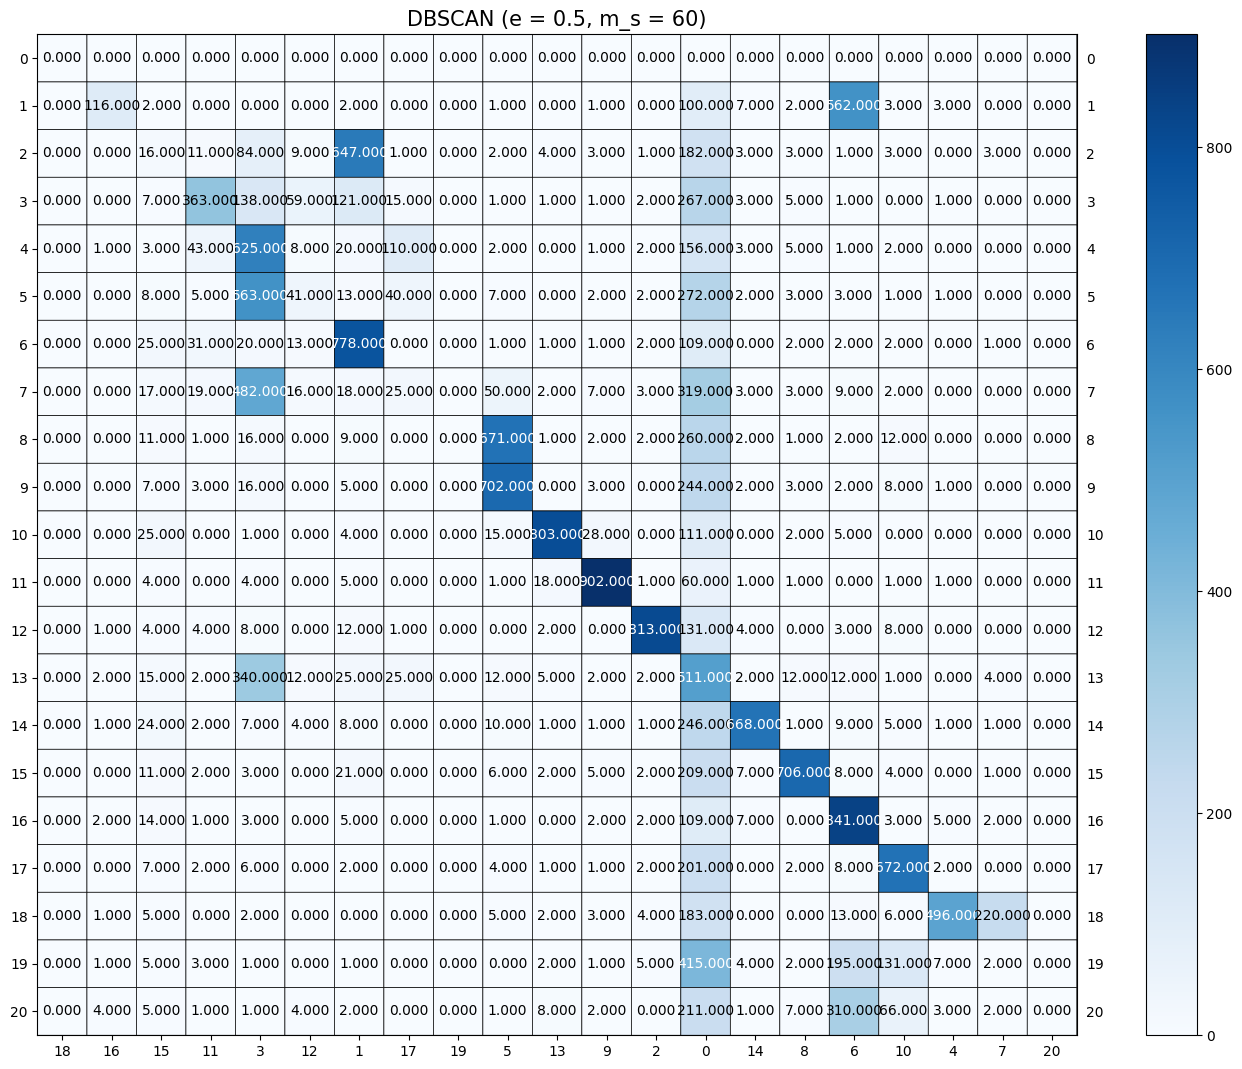

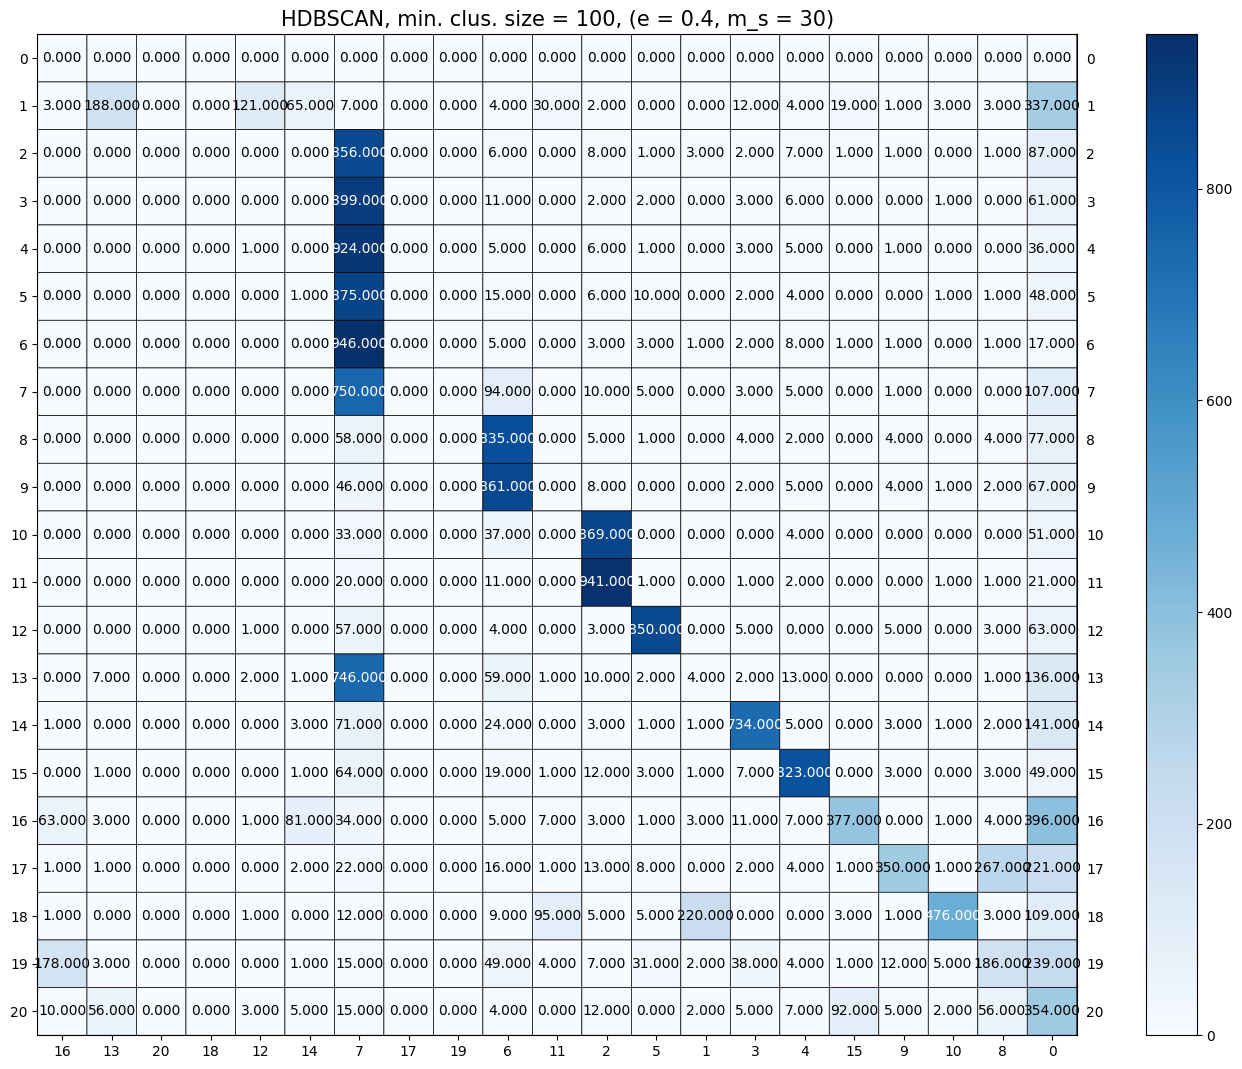

In [ ]:
dbs = DBSCAN(eps=best_eps_db,min_samples=best_minSample_db ,n_jobs=-1).fit_predict(Umap_cos)
cm = confusion_matrix(dataset.target, dbs)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'DBSCAN (e = 0.5, m_s = 60)', size=(14,12))

hdbs = hdbscan.HDBSCAN(min_cluster_size=100,cluster_selection_epsilon=best_eps_hdb,min_samples=best_minSample_hdb,core_dist_n_jobs=-1).fit_predict(Umap_cos)
cm = confusion_matrix(dataset.target, hdbs)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, title = 'HDBSCAN, min. clus. size = 100, (e = 0.4, m_s = 30)', size=(14,12))

According to official document, **-1** stands for noise: points alone in their cluster. This means points that have less than min_sample neighbors in the eps neighbourhood. The number of clusters is shown in the graph above.

# QUESTION 17

# QUESTION 18

# QUESTION 19
###In a brief paragraph discuss: If the VGG network is trained on a dataset with perhaps totally different classes as targets, why would one expect the features derived from such a network to have discriminative power for a custom dataset?

While the VGG net may not be trained on the particular images we are interested in, it stands to reason that a pretrained image recognition network is able to identify useful features in any image. Thus, it's expected that the output of one of the last layers in the network would be usable as "expert features", and feature engineering techniques we have used in previous assignments could use these expert features effectively.

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


# Flowers Dataset and VGG Features

In [ ]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 151MB/s]
100%|██████████| 58/58 [00:45<00:00,  1.26it/s]


In [12]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

2
(3670, 4096) (3670,)


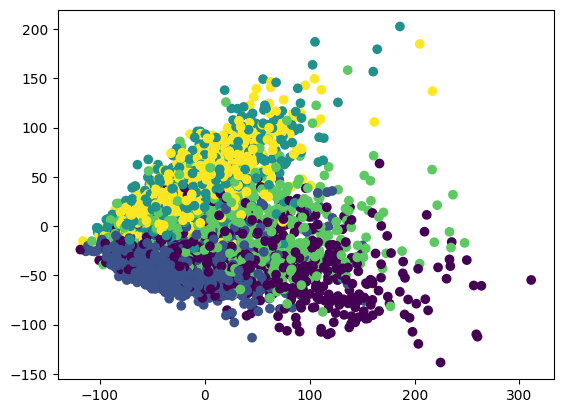

In [ ]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

# MLP Classifier

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                ##################################
                raise NotImplementedError
        return self
    
    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        ##################################
        raise NotImplementedError

# Autoencoder

In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


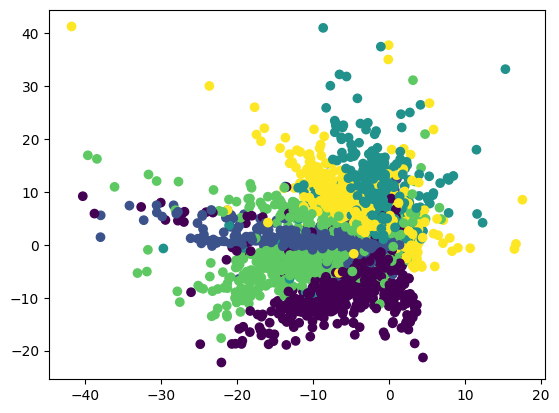

In [ ]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

# QUESTION 20
###In a brief paragraph explain how the helper code base is performing feature extraction.

First, the dataset is cropped and normalized, and then fed to the VGG network. The VGG network feeds the data through a fully-connected layer, maxpool layer, and flattens the output into a 3670 feature vector.

# QUESTION 21
###How many pixels are there in the original images? How many features does the VGG network extract per image; i.e what is the dimension of each feature vector for an image sample?

The original images have 500x333 resolution apiece (166,500 pixels). These are cropped to 244x244 resolution (59536 pixels). The VGG network extracts 3670 features per image.

# QUESTION 22
###Are the extracted features dense or sparse? (Compare with sparse TF-IDF features in text.)

# QUESTION 23
###In order to inspect the high-dimensional features, t-SNE is a popular off-the-shelf choice for visualizing Vision features. Map the features you have extracted onto 2 dimensions with t-SNE. Then plot the mapped feature vectors along x and y axes. Color-code the data points with ground-truth labels. Describe your observation.